# Preprocessing

## Packages

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import torch

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style
set_style("whitegrid")

## Load data

In [2]:
tech = pd.read_csv("../data/tech_data.csv", parse_dates=True)
biotech = pd.read_csv("../data/biotech_data.csv", parse_dates=True)
healthcare = pd.read_csv("../data/healthcare_data.csv", parse_dates=True)
industrial = pd.read_csv("../data/industrial_data.csv", parse_dates=True)

In [3]:
## get the tickers
tech_tickers = list(tech.columns[1:])
biotech_tickers = list(biotech.columns[1:])
healthcare_tickers = list(healthcare.columns[1:])
industrial_tickers = list(industrial.columns[1:])

for i in range(5):
    ## tech stocks
    tech[f"{tech_tickers[i]}_returns"] = np.log(tech[tech_tickers[i]]) - np.log(tech[tech_tickers[i]].shift(-1))
    tech[f"{tech_tickers[i]}_volatility"] = tech[f"{tech_tickers[i]}_returns"].rolling(30).std()

    ## biotech stocks
    biotech[f"{biotech_tickers[i]}_returns"] = np.log(biotech[biotech_tickers[i]]) - np.log(biotech[biotech_tickers[i]].shift(-1))
    biotech[f"{biotech_tickers[i]}_volatility"] = biotech[f"{biotech_tickers[i]}_returns"].rolling(30).std()

    ## healthcare stocks
    healthcare[f"{healthcare_tickers[i]}_returns"] = np.log(healthcare[healthcare_tickers[i]]) - np.log(healthcare[healthcare_tickers[i]].shift(-1))
    healthcare[f"{healthcare_tickers[i]}_volatility"] = healthcare[f"{healthcare_tickers[i]}_returns"].rolling(30).std()

    ## industrial stocks
    industrial[f"{industrial_tickers[i]}_returns"] = np.log(industrial[industrial_tickers[i]]) - np.log(industrial[industrial_tickers[i]].shift(-1))
    industrial[f"{industrial_tickers[i]}_volatility"] = industrial[f"{industrial_tickers[i]}_returns"].rolling(30).std()


## remove missing values
tech.dropna(inplace=True)
biotech.dropna(inplace=True)
healthcare.dropna(inplace=True)
industrial.dropna(inplace=True)

## reset the index
tech.reset_index(inplace=True, drop=True)
biotech.reset_index(inplace=True, drop=True)
healthcare.reset_index(inplace=True, drop=True)
industrial.reset_index(inplace=True, drop=True)

## Create train, val, test split and convert to torch tensors

In [4]:
from utils.dataset_factory import train_val_test_split

In [5]:
tech_train, tech_val, tech_test = train_val_test_split(tech, val_ratio=0.1, test_ratio=0.1)
biotech_train, biotech_val, biotech_test = train_val_test_split(biotech, val_ratio=0.1, test_ratio=0.1)
healthcare_train, healthcare_val, healthcare_test = train_val_test_split(healthcare, val_ratio=0.1, test_ratio=0.1)
industrial_train, industrial_val, industrial_test = train_val_test_split(industrial, val_ratio=0.1, test_ratio=0.1)

# LSTM Fitting

In [6]:
from model.volatility_lstm import VolatilityLSTM
from single_experiment import train_model, test_model

MODEL_CONFIGS = {
    "window_size": 30,
    "lstm_hidden_size": 128,
    "n_lstm_layers": 4,
    "dense_hidden_sizes": [32],
    "n_dense_layers": 1,
    "dropout": 0.0,
    "dropout_lstm": False
}

TRAIN_CONFIG = {
    'patience': 100,
    'max_iter': 5000
}

In [7]:
## empty dictionaries to hold the average MSES, models, mean, and std for each stock
tech_results = {}
tech_models = {}
tech_means = {}
tech_stds = {}

for stock in tech_tickers:
    print(f'Start training {stock}')
    start_time = datetime.now()
    
    train_tensor = torch.tensor(tech_train[f'{stock}_volatility'].values, dtype=torch.float)
    mean, std = train_tensor.mean().item(), train_tensor.std().item()
    train_tensor = (train_tensor - mean) / std
    tech_means[stock] = mean
    tech_stds[stock] = std
    
    val_tensor = torch.tensor(tech_val[f'{stock}_volatility'].values, dtype=torch.float)
    val_tensor = (val_tensor - mean) / std
    
    X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    X_val = val_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_val = val_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    model = VolatilityLSTM(**MODEL_CONFIGS)
    
    best_model, best_val_loss, total_epochs = train_model(model,
                                                          X_train,
                                                          y_train,
                                                          X_val,
                                                          y_val,
                                                          **TRAIN_CONFIG)
    
    tech_results[stock] = best_val_loss
    tech_models[stock] = best_model
    
    end_time = datetime.now()
    
    print(f'Done training {stock} for {total_epochs} epochs\tTook {end_time-start_time}')
    

Start training AAPL
Done training AAPL for 1695 epochs	Took 0:05:52.195769
Start training AMZN
Done training AMZN for 1986 epochs	Took 0:07:12.249652
Start training GOOGL
Done training GOOGL for 1982 epochs	Took 0:07:01.515820
Start training MSFT
Done training MSFT for 639 epochs	Took 0:02:18.679479
Start training NVDA
Done training NVDA for 2415 epochs	Took 0:08:55.198259


In [8]:
def print_results(stock_results):
    print('Stock\tValidation MSE')
    for stock, val_mse in stock_results.items():
        print(f'{stock}\t{val_mse}')

In [9]:
print_results(tech_results)

Stock	Validation MSE
AAPL	0.1426738202571869
AMZN	0.09942605346441269
GOOGL	0.06916667520999908
MSFT	0.18466544151306152
NVDA	0.04884563386440277


In [10]:
## empty dictionaries to hold the average MSES, models, mean, and std for each stock
biotech_results = {}
biotech_models = {}
biotech_means = {}
biotech_stds = {}

for stock in biotech_tickers:
    print(f'Start training {stock}')
    start_time = datetime.now()
    
    train_tensor = torch.tensor(biotech_train[f'{stock}_volatility'].values, dtype=torch.float)
    mean, std = train_tensor.mean().item(), train_tensor.std().item()
    train_tensor = (train_tensor - mean) / std
    biotech_means[stock] = mean
    biotech_stds[stock] = std
    
    val_tensor = torch.tensor(biotech_val[f'{stock}_volatility'].values, dtype=torch.float)
    val_tensor = (val_tensor - mean) / std
    
    X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    X_val = val_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_val = val_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    model = VolatilityLSTM(**MODEL_CONFIGS)
    
    best_model, best_val_loss, total_epochs = train_model(model,
                                                          X_train,
                                                          y_train,
                                                          X_val,
                                                          y_val,
                                                          **TRAIN_CONFIG)
    
    biotech_results[stock] = best_val_loss
    biotech_models[stock] = best_model
    
    end_time = datetime.now()
    
    print(f'Done training {stock} for {total_epochs} epochs\tTook {end_time-start_time}')
    

Start training JNJ
Done training JNJ for 1033 epochs	Took 0:03:58.034611
Start training LLY
Done training LLY for 2545 epochs	Took 0:09:31.444208
Start training MRK
Done training MRK for 1630 epochs	Took 0:06:04.976519
Start training NVO
Done training NVO for 1766 epochs	Took 0:06:32.962243
Start training RHHBY
Done training RHHBY for 565 epochs	Took 0:02:04.855134


In [11]:
print_results(biotech_results)

Stock	Validation MSE
JNJ	0.051898423582315445
LLY	0.5200978517532349
MRK	0.05196352303028107
NVO	0.1038360595703125
RHHBY	0.2218264937400818


In [12]:
## empty dictionaries to hold the average MSES, models, mean, and std for each stock
healthcare_results = {}
healthcare_models = {}
healthcare_means = {}
healthcare_stds = {}

for stock in healthcare_tickers:
    print(f'Start training {stock}')
    start_time = datetime.now()
    
    train_tensor = torch.tensor(healthcare_train[f'{stock}_volatility'].values, dtype=torch.float)
    mean, std = train_tensor.mean().item(), train_tensor.std().item()
    train_tensor = (train_tensor - mean) / std
    healthcare_means[stock] = mean
    healthcare_stds[stock] = std
    
    val_tensor = torch.tensor(healthcare_val[f'{stock}_volatility'].values, dtype=torch.float)
    val_tensor = (val_tensor - mean) / std
    
    X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    X_val = val_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_val = val_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    model = VolatilityLSTM(**MODEL_CONFIGS)
    
    best_model, best_val_loss, total_epochs = train_model(model,
                                                          X_train,
                                                          y_train,
                                                          X_val,
                                                          y_val,
                                                          **TRAIN_CONFIG)
    
    healthcare_results[stock] = best_val_loss
    healthcare_models[stock] = best_model
    
    end_time = datetime.now()
    
    print(f'Done training {stock} for {total_epochs} epochs\tTook {end_time-start_time}')
    

Start training AMGN
Done training AMGN for 1002 epochs	Took 0:03:39.765373
Start training CVS
Done training CVS for 2476 epochs	Took 0:09:07.881070
Start training ELV
Done training ELV for 2520 epochs	Took 0:09:17.232507
Start training PFE
Done training PFE for 2186 epochs	Took 0:08:02.979599
Start training UNH
Done training UNH for 395 epochs	Took 0:01:26.952591


In [13]:
print_results(healthcare_results)

Stock	Validation MSE
AMGN	0.23345947265625
CVS	0.06846979260444641
ELV	0.05679374560713768
PFE	0.12661343812942505
UNH	0.2854832410812378


In [14]:
## empty dictionaries to hold the average MSES, models, mean, and std for each stock
industrial_results = {}
industrial_models = {}
industrial_means = {}
industrial_stds = {}

for stock in industrial_tickers:
    print(f'Start training {stock}')
    start_time = datetime.now()
    
    train_tensor = torch.tensor(industrial_train[f'{stock}_volatility'].values, dtype=torch.float)
    mean, std = train_tensor.mean().item(), train_tensor.std().item()
    train_tensor = (train_tensor - mean) / std
    industrial_means[stock] = mean
    industrial_stds[stock] = std
    
    val_tensor = torch.tensor(industrial_val[f'{stock}_volatility'].values, dtype=torch.float)
    val_tensor = (val_tensor - mean) / std
    
    X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    X_val = val_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
    y_val = val_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)
    
    model = VolatilityLSTM(**MODEL_CONFIGS)
    
    best_model, best_val_loss, total_epochs = train_model(model,
                                                          X_train,
                                                          y_train,
                                                          X_val,
                                                          y_val,
                                                          **TRAIN_CONFIG)
    
    industrial_results[stock] = best_val_loss
    industrial_models[stock] = best_model
    
    end_time = datetime.now()
    
    print(f'Done training {stock} for {total_epochs} epochs\tTook {end_time-start_time}')
    

Start training F
Done training F for 384 epochs	Took 0:01:25.429543
Start training GE
Done training GE for 101 epochs	Took 0:00:22.007924
Start training NEE
Done training NEE for 101 epochs	Took 0:00:22.016711
Start training SO
Done training SO for 511 epochs	Took 0:01:52.003397
Start training UNP
Done training UNP for 1858 epochs	Took 0:06:51.163494


In [15]:
print_results(industrial_results)

Stock	Validation MSE
F	0.2741054594516754
GE	0.7663648724555969
NEE	0.6696215867996216
SO	0.08988338708877563
UNP	0.05793701112270355


# Evaluating Forecasts

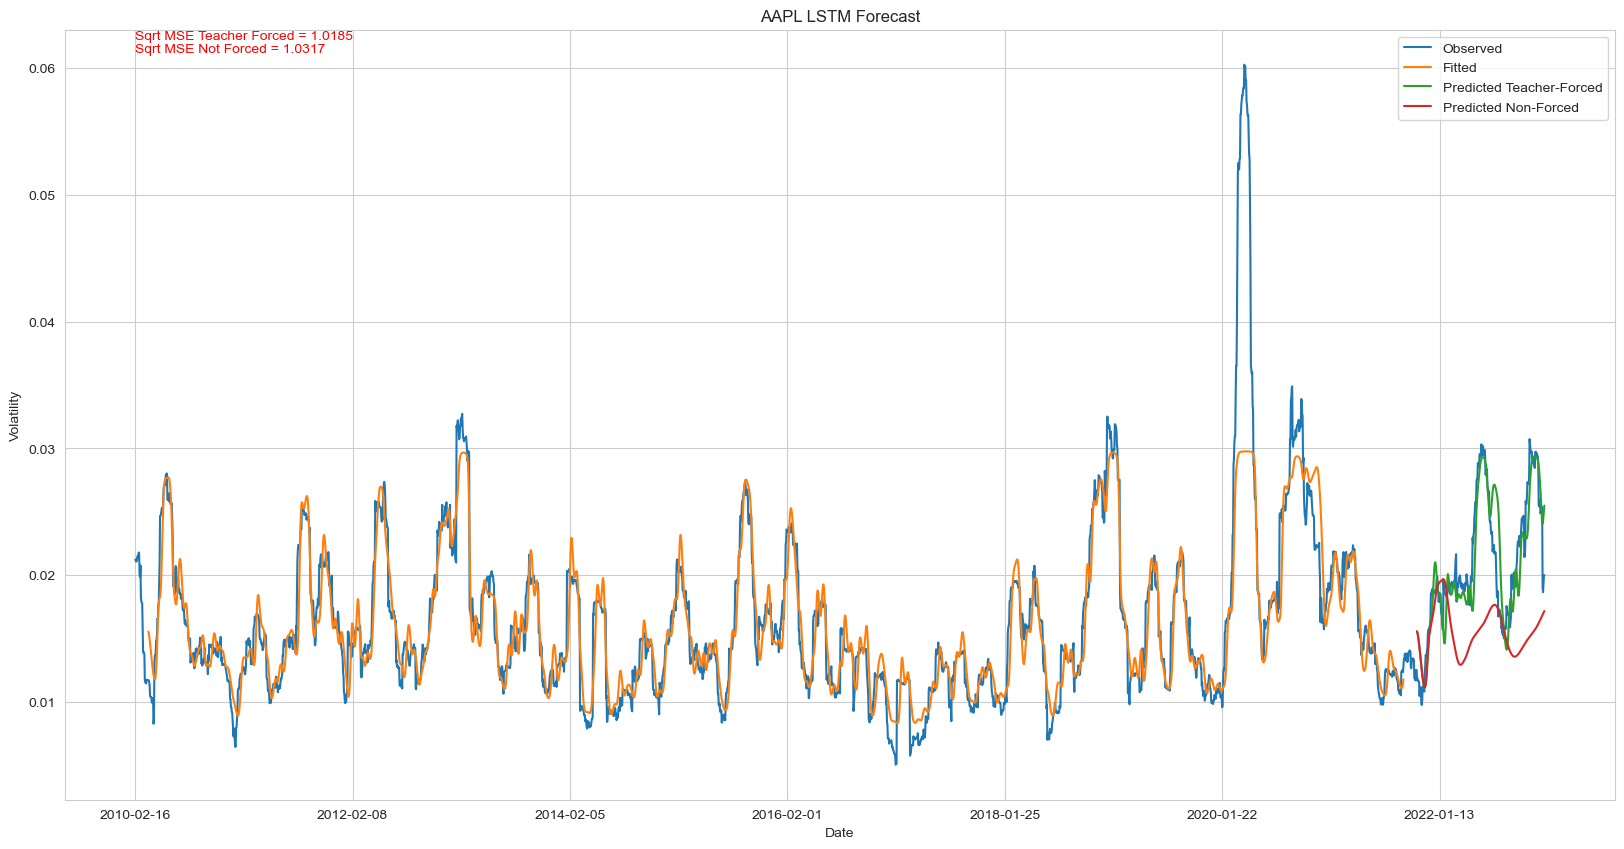

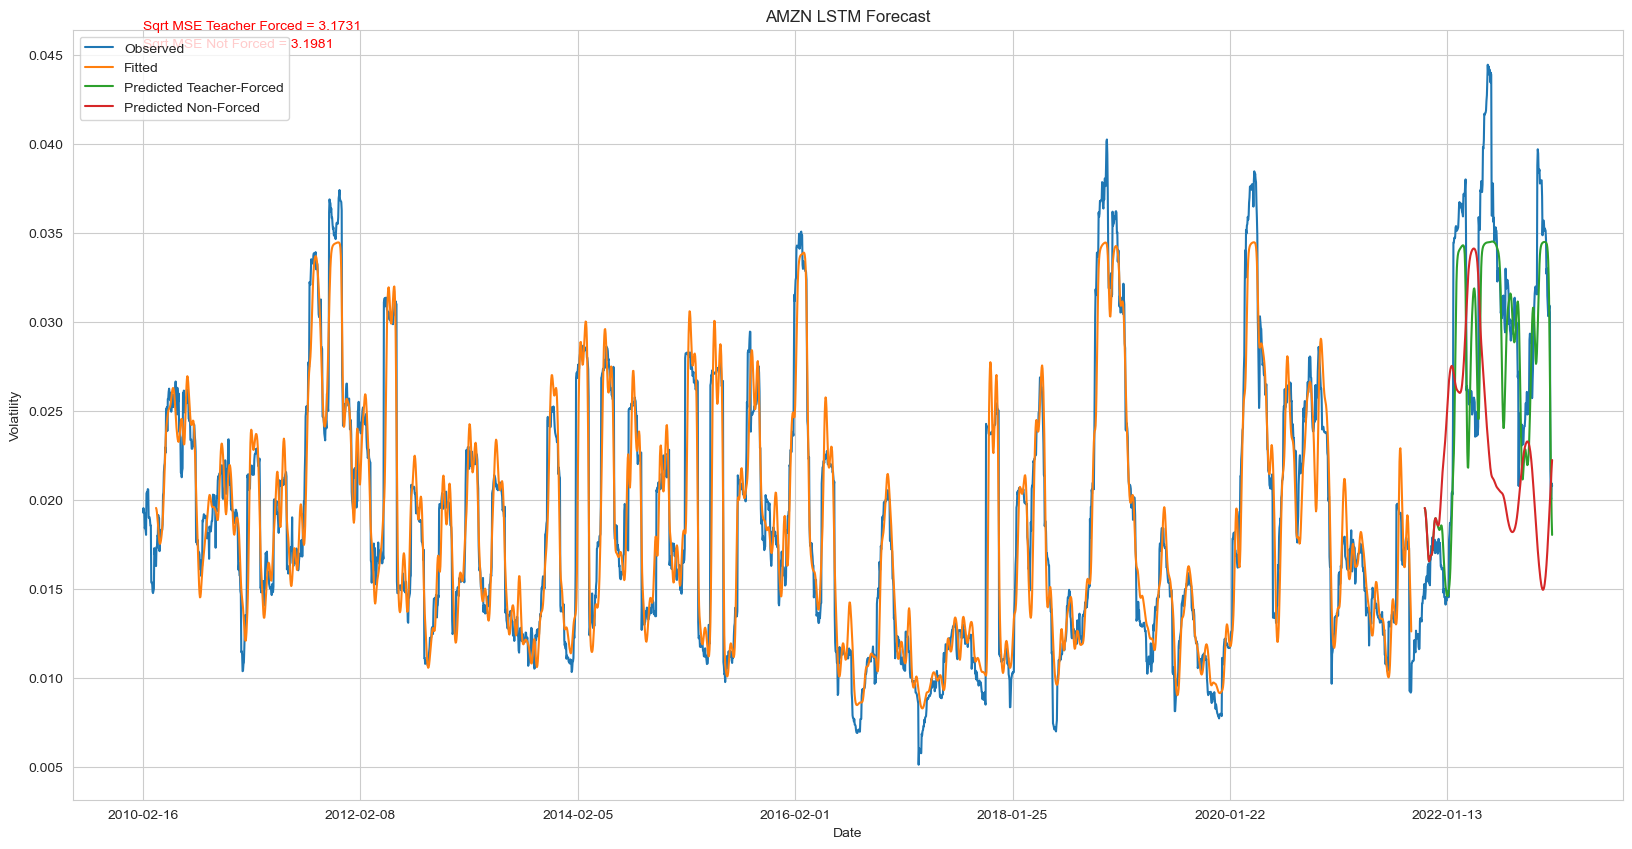

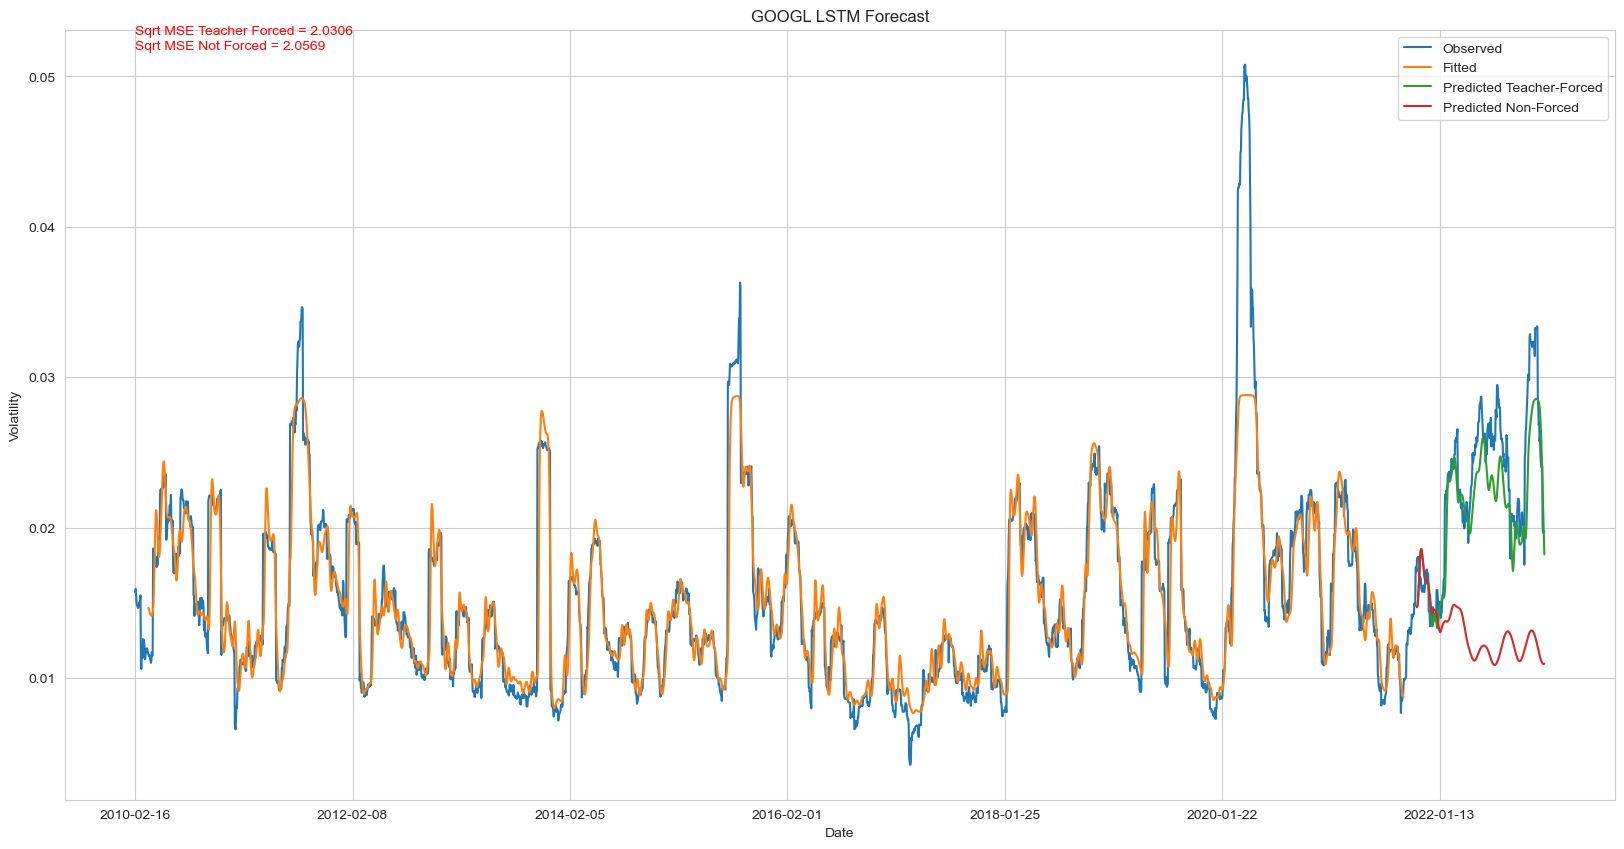

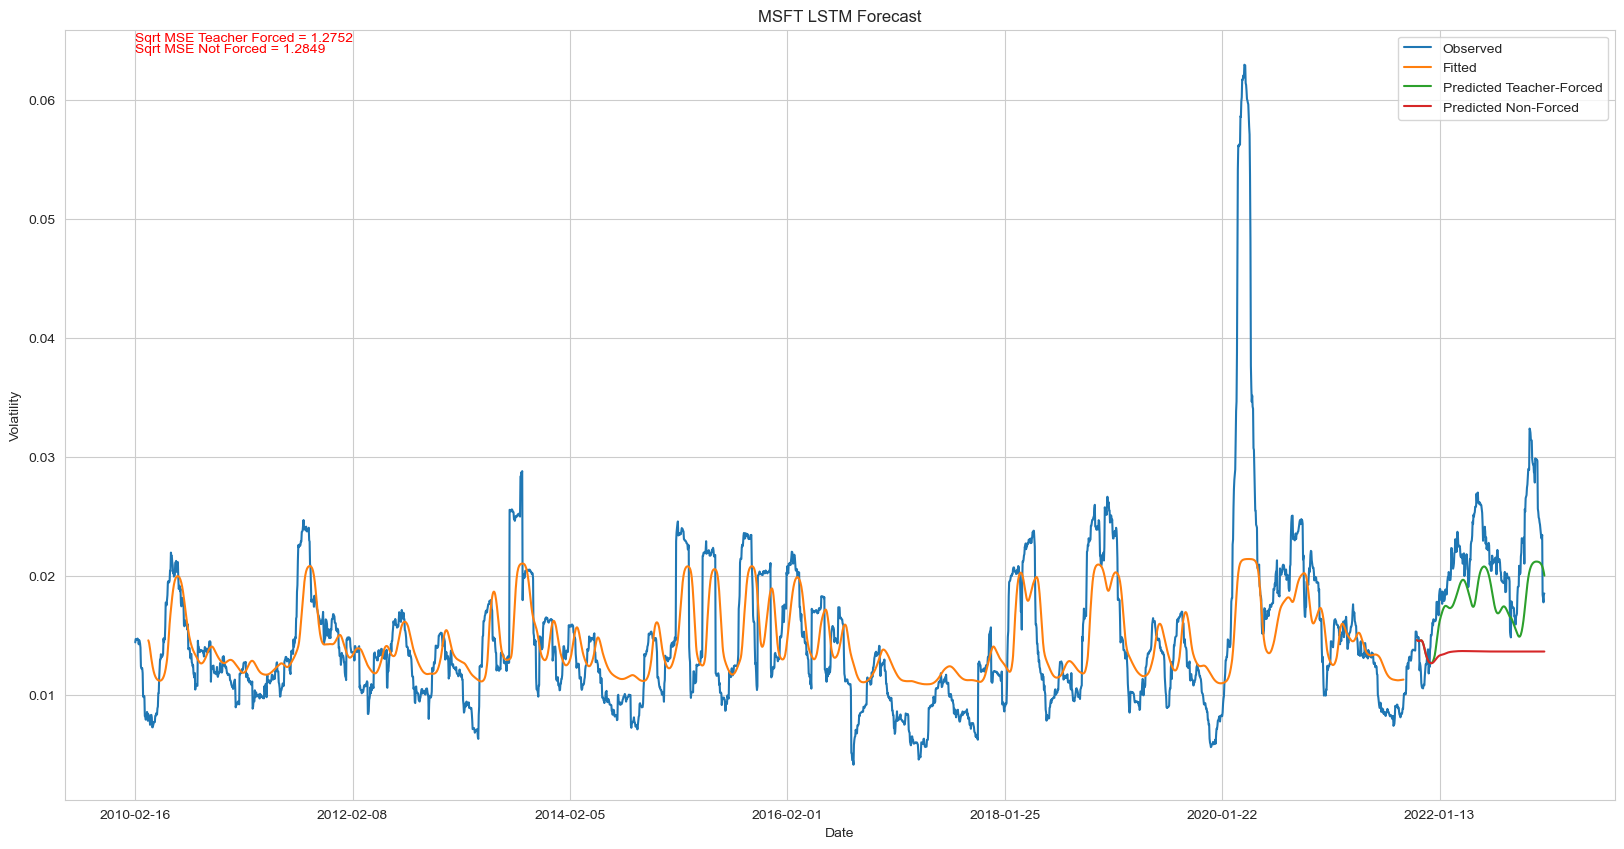

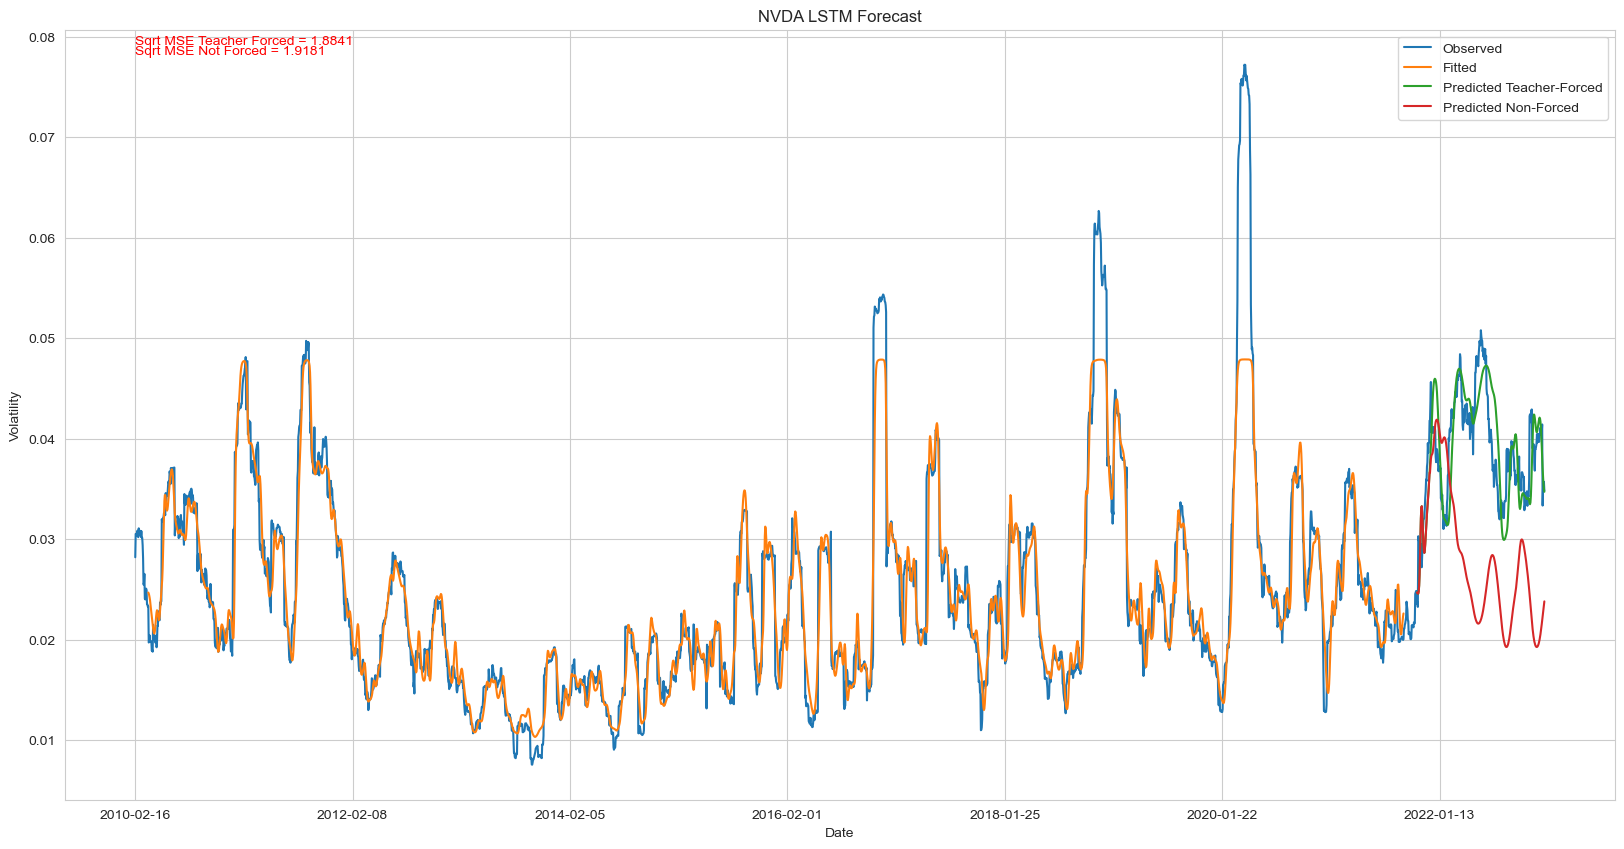

In [16]:
tech_test_mses = {}

with torch.no_grad():
    for stock in tech_tickers:
        window=MODEL_CONFIGS['window_size']

        full_train = pd.concat([tech_train, tech_val])
        train_tensor = torch.tensor(full_train[f'{stock}_volatility'].values, dtype=torch.float)
        mean, std = tech_means[stock], tech_stds[stock]
        train_tensor = (train_tensor - mean) / std

        test_tensor = torch.tensor(tech_test[f'{stock}_volatility'].values, dtype=torch.float)
        test_tensor = (test_tensor - mean) / std

        X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        X_test = test_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_test = test_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        model = tech_models[stock]

        fitted, _ = model(X_train)
        pred_forced, _ = model(X_test)
        # predicting the values given a 30 day initial set
        pred_infer = model.predict(X_test[:, :30, :], n_days=y_test.size(1) - 30, keep_init=True)
        
        fitted = (fitted * std) + mean
        pred_forced = (pred_forced * std) + mean
        pred_infer = (pred_infer * std) + mean

        criterion = torch.nn.MSELoss()
        loss_forced = criterion(pred_forced[:, :-1], y_test).item()
        loss_infer = criterion(pred_infer, y_test).item()

        ## make dataframes to be plotted
        obs_df = pd.DataFrame(data=tech[f"{stock}_volatility"].values,
                              index=tech.Date,
                              columns=["Observed"])

        fit_df = pd.DataFrame(data=fitted[:, :-1].squeeze().numpy(),
                              index=full_train.Date[window:],
                              columns=["Fitted"])

        pred_forced_df = pd.DataFrame(data=pred_forced[:, :-1].squeeze().numpy(),
                               index=tech_test.Date[window:],
                               columns=["Predicted Teacher-Forced"])
        pred_infer_df = pd.DataFrame(data=pred_infer.squeeze().numpy(),
                                    index=tech_test.Date[window:],
                                    columns=["Predicted Non-Forced"])

        df = pd.concat([obs_df, fit_df, pred_forced_df, pred_infer_df], axis=1)

        ## make the plot 
        ax = df.plot(y=["Observed", "Fitted", "Predicted Teacher-Forced", "Predicted Non-Forced"],
            figsize=(20,10),
            ylabel="Volatility",
            title=f"{stock} LSTM Forecast")
        ax.text(0,df["Observed"].max() + 0.002, f"Sqrt MSE Teacher Forced = {loss_forced:.4f}",
                color="red")
        ax.text(0,df["Observed"].max() + 0.001, f"Sqrt MSE Not Forced = {loss_infer:.4f}",
                color="red")

        tech_test_mses[stock] = (loss_forced, loss_infer)


In [17]:
def print_mse_results(mses):
    print('Stock\tTest MSE Forced\t\tTest MSE Not Forced')
    for stock, mse in mses.items():
        print(f'{stock}\t{mse[0]}\t{mse[1]}')

In [18]:
print_mse_results(tech_test_mses)

Stock	Test MSE Forced		Test MSE Not Forced
AAPL	1.0184714794158936	1.0317330360412598
AMZN	3.1731116771698	3.1981406211853027
GOOGL	2.030637502670288	2.0569145679473877
MSFT	1.2751792669296265	1.2849116325378418
NVDA	1.8841289281845093	1.9181090593338013


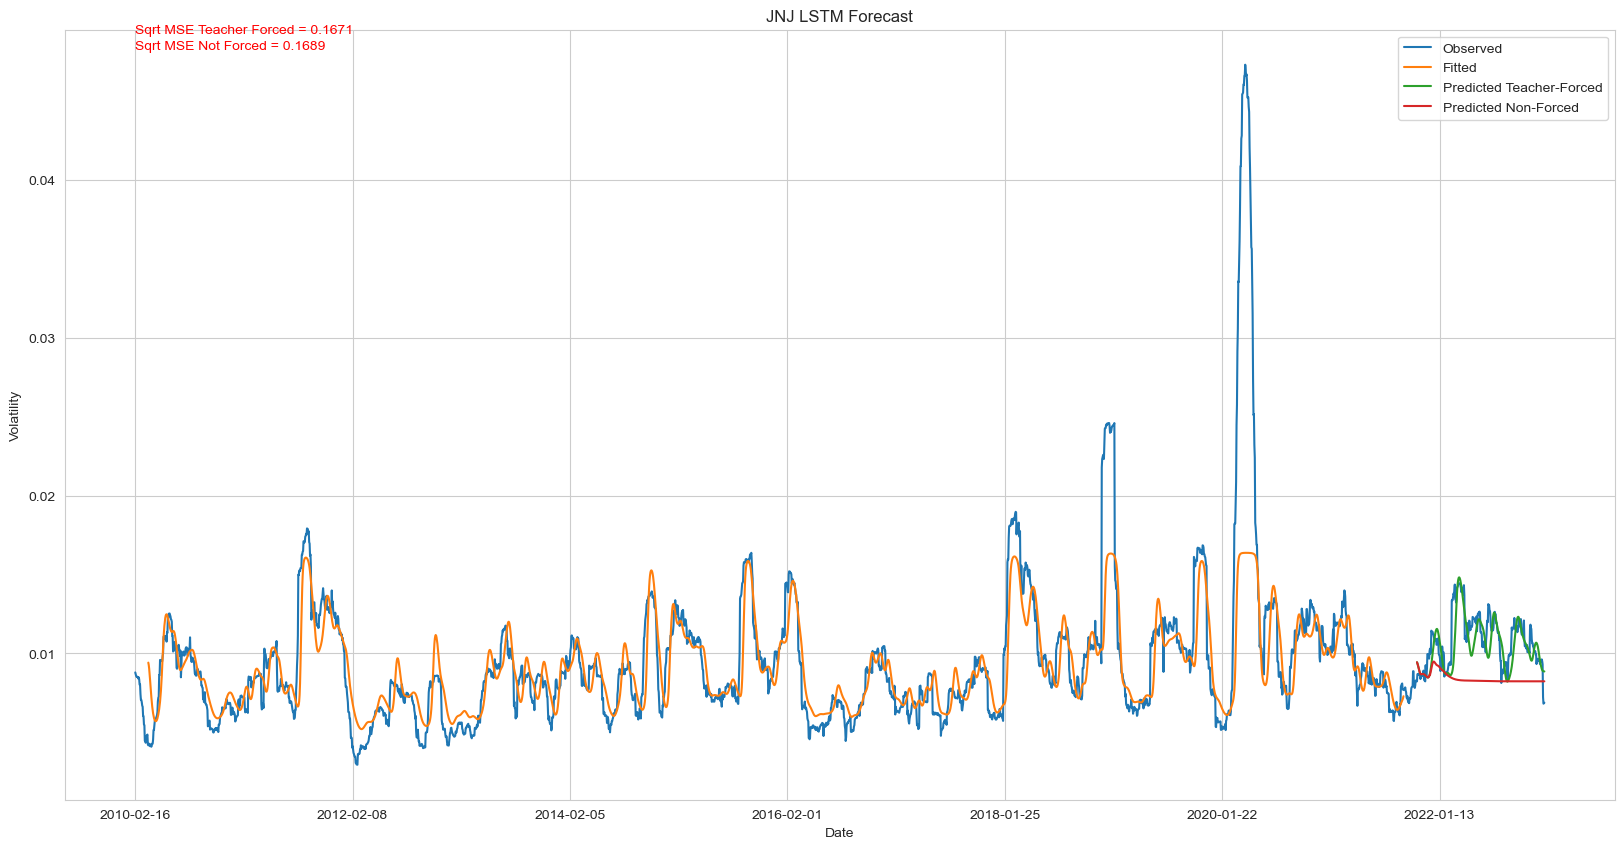

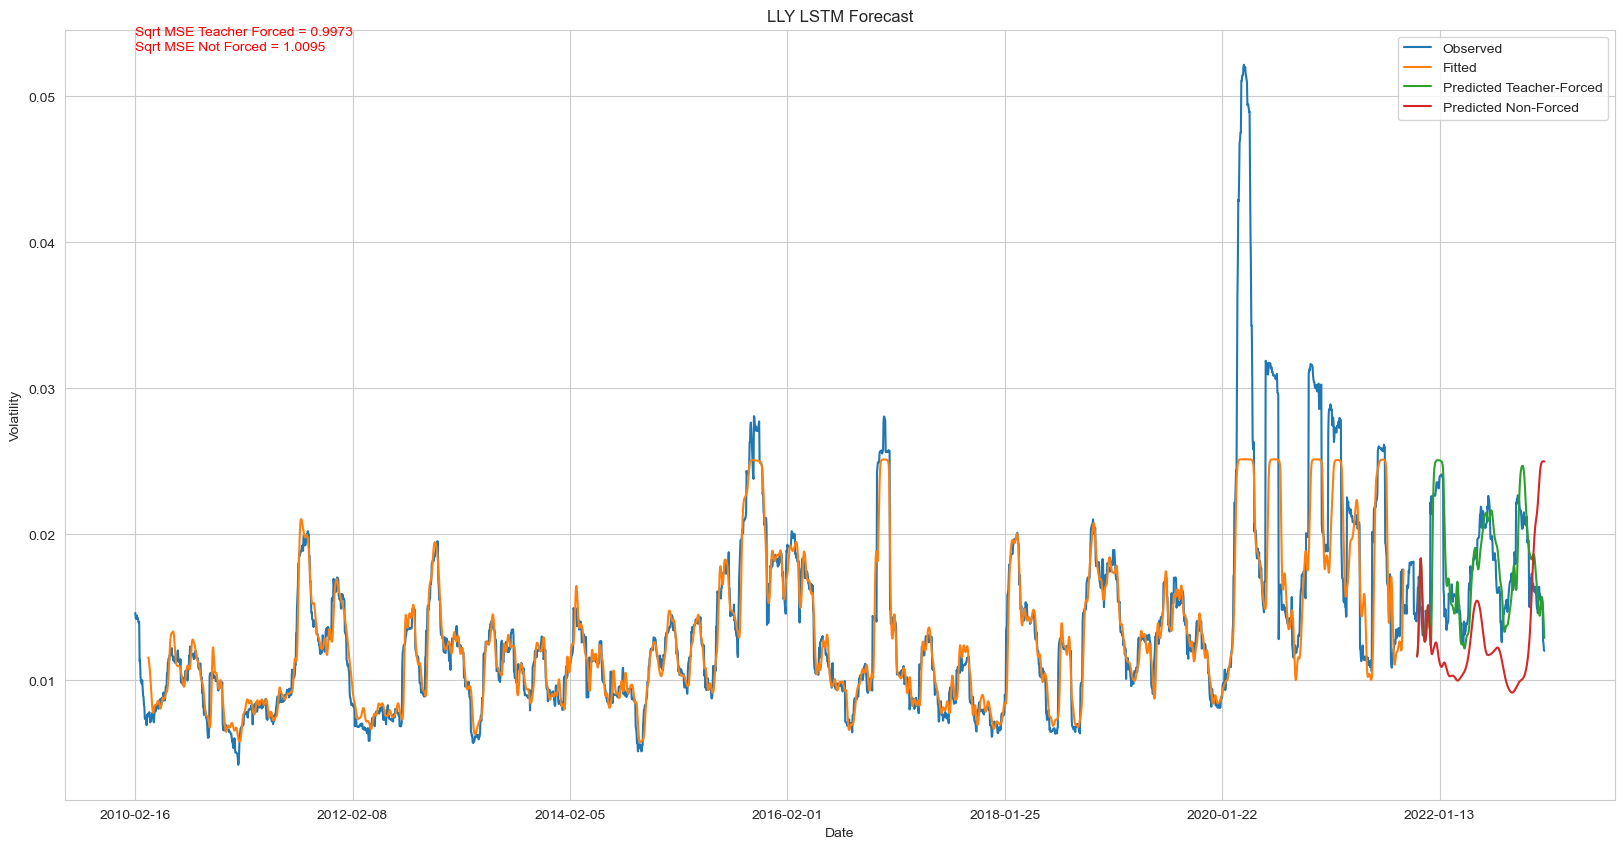

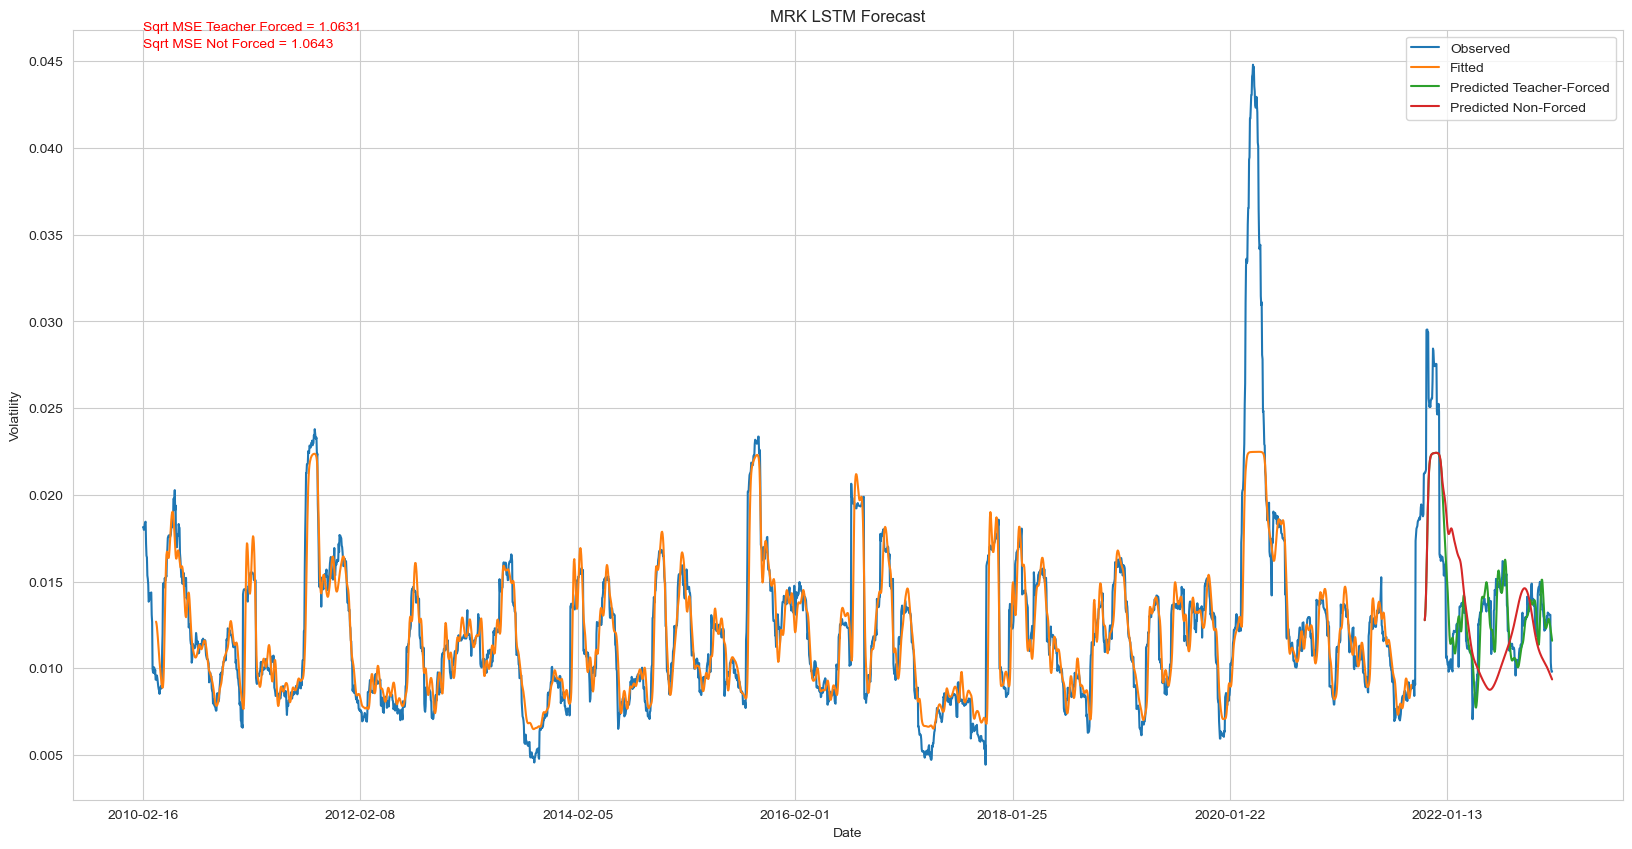

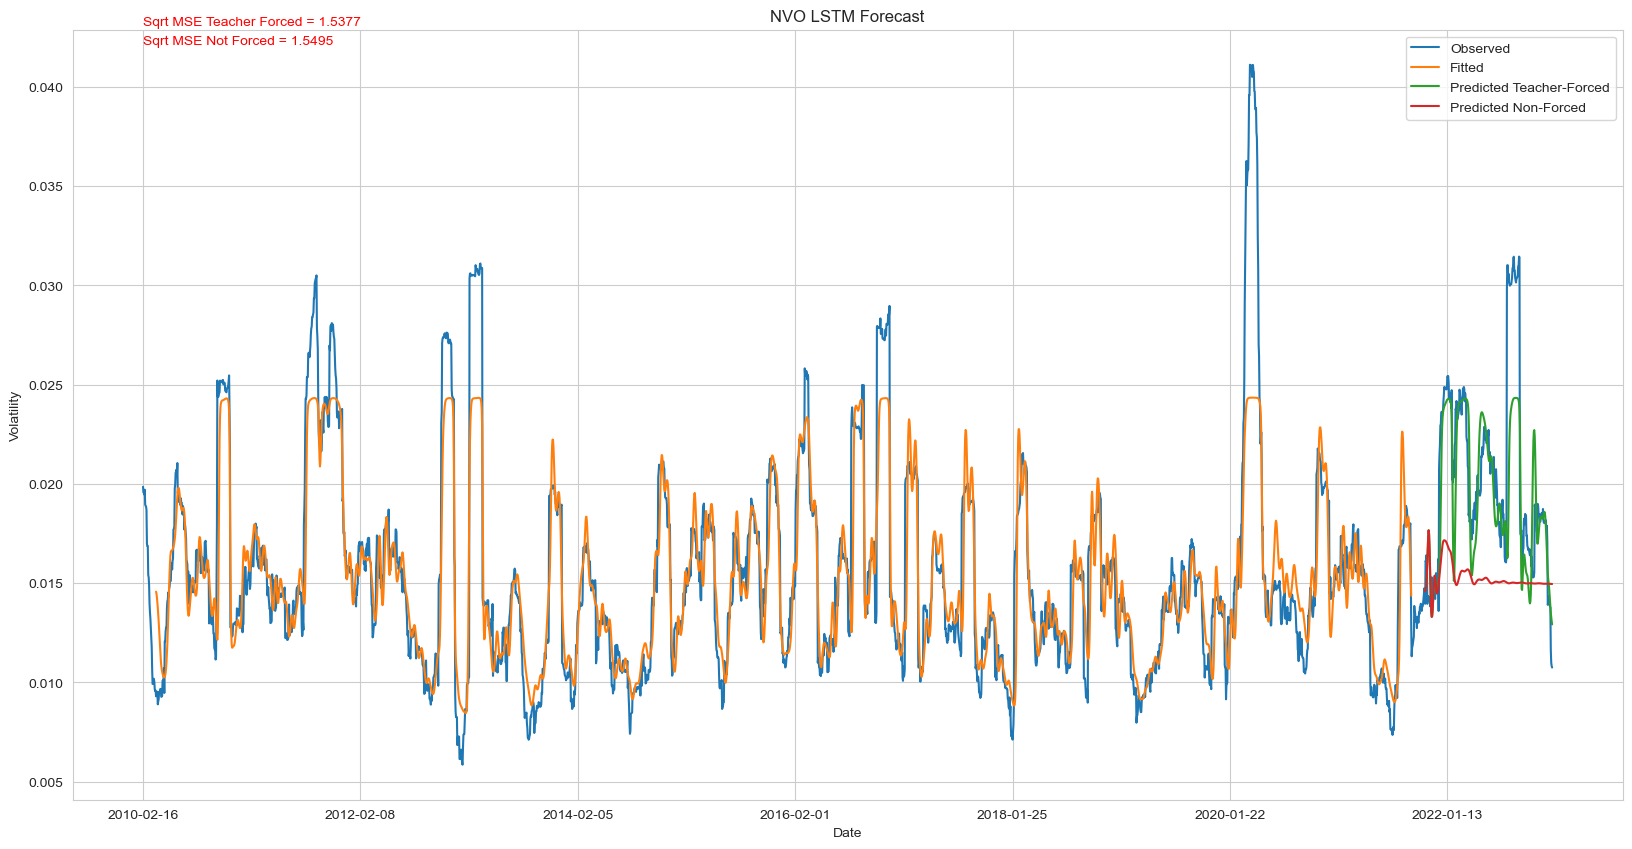

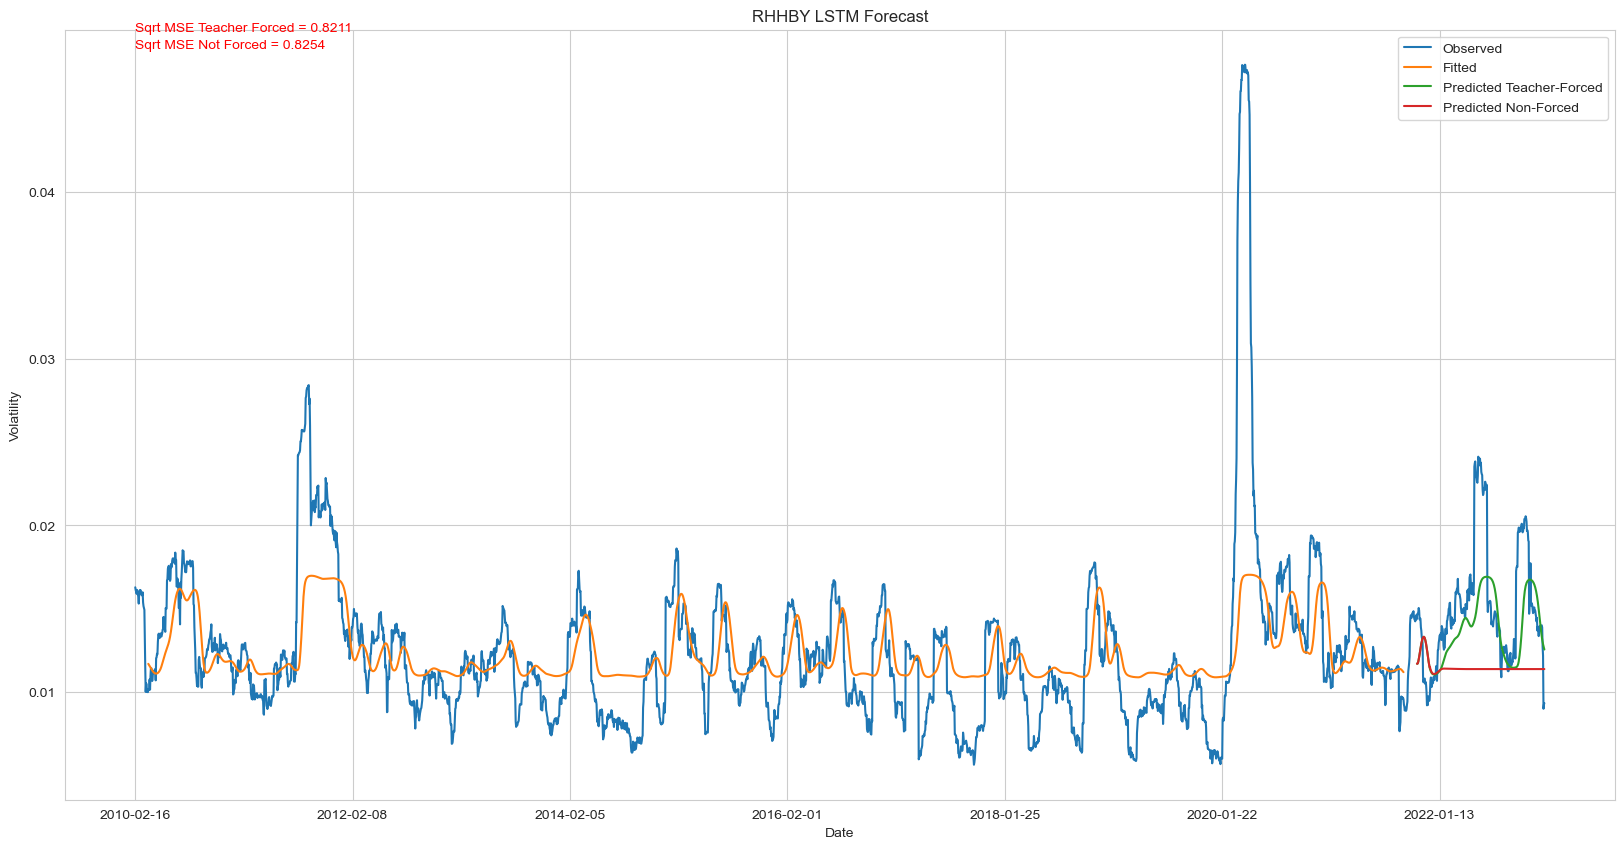

In [19]:
biotech_test_mses = {}

with torch.no_grad():
    for stock in biotech_tickers:
        window=MODEL_CONFIGS['window_size']

        full_train = pd.concat([biotech_train, biotech_val])
        train_tensor = torch.tensor(full_train[f'{stock}_volatility'].values, dtype=torch.float)
        mean, std = biotech_means[stock], biotech_stds[stock]
        train_tensor = (train_tensor - mean) / std

        test_tensor = torch.tensor(biotech_test[f'{stock}_volatility'].values, dtype=torch.float)
        test_tensor = (test_tensor - mean) / std

        X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        X_test = test_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_test = test_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        model = biotech_models[stock]

        fitted, _ = model(X_train)
        pred_forced, _ = model(X_test)
        # predicting the values given a 30 day initial set
        pred_infer = model.predict(X_test[:, :30, :], n_days=y_test.size(1) - 30, keep_init=True)
        
        fitted = (fitted * std) + mean
        pred_forced = (pred_forced * std) + mean
        pred_infer = (pred_infer * std) + mean

        criterion = torch.nn.MSELoss()
        loss_forced = criterion(pred_forced[:, :-1], y_test).item()
        loss_infer = criterion(pred_infer, y_test).item()

        ## make dataframes to be plotted
        obs_df = pd.DataFrame(data=biotech[f"{stock}_volatility"].values,
                              index=biotech.Date,
                              columns=["Observed"])

        fit_df = pd.DataFrame(data=fitted[:, :-1].squeeze().numpy(),
                              index=full_train.Date[window:],
                              columns=["Fitted"])

        pred_forced_df = pd.DataFrame(data=pred_forced[:, :-1].squeeze().numpy(),
                               index=biotech_test.Date[window:],
                               columns=["Predicted Teacher-Forced"])
        pred_infer_df = pd.DataFrame(data=pred_infer.squeeze().numpy(),
                                    index=biotech_test.Date[window:],
                                    columns=["Predicted Non-Forced"])

        df = pd.concat([obs_df, fit_df, pred_forced_df, pred_infer_df], axis=1)

        ## make the plot 
        ax = df.plot(y=["Observed", "Fitted", "Predicted Teacher-Forced", "Predicted Non-Forced"],
            figsize=(20,10),
            ylabel="Volatility",
            title=f"{stock} LSTM Forecast")
        ax.text(0,df["Observed"].max() + 0.002, f"Sqrt MSE Teacher Forced = {loss_forced:.4f}",
                color="red")
        ax.text(0,df["Observed"].max() + 0.001, f"Sqrt MSE Not Forced = {loss_infer:.4f}",
                color="red")

        biotech_test_mses[stock] = (loss_forced, loss_infer)


In [20]:
print_mse_results(biotech_test_mses)

Stock	Test MSE Forced		Test MSE Not Forced
JNJ	0.16711696982383728	0.1689375340938568
LLY	0.9973142743110657	1.009539246559143
MRK	1.06308913230896	1.0642728805541992
NVO	1.537684440612793	1.5495121479034424
RHHBY	0.8210852742195129	0.8254159092903137


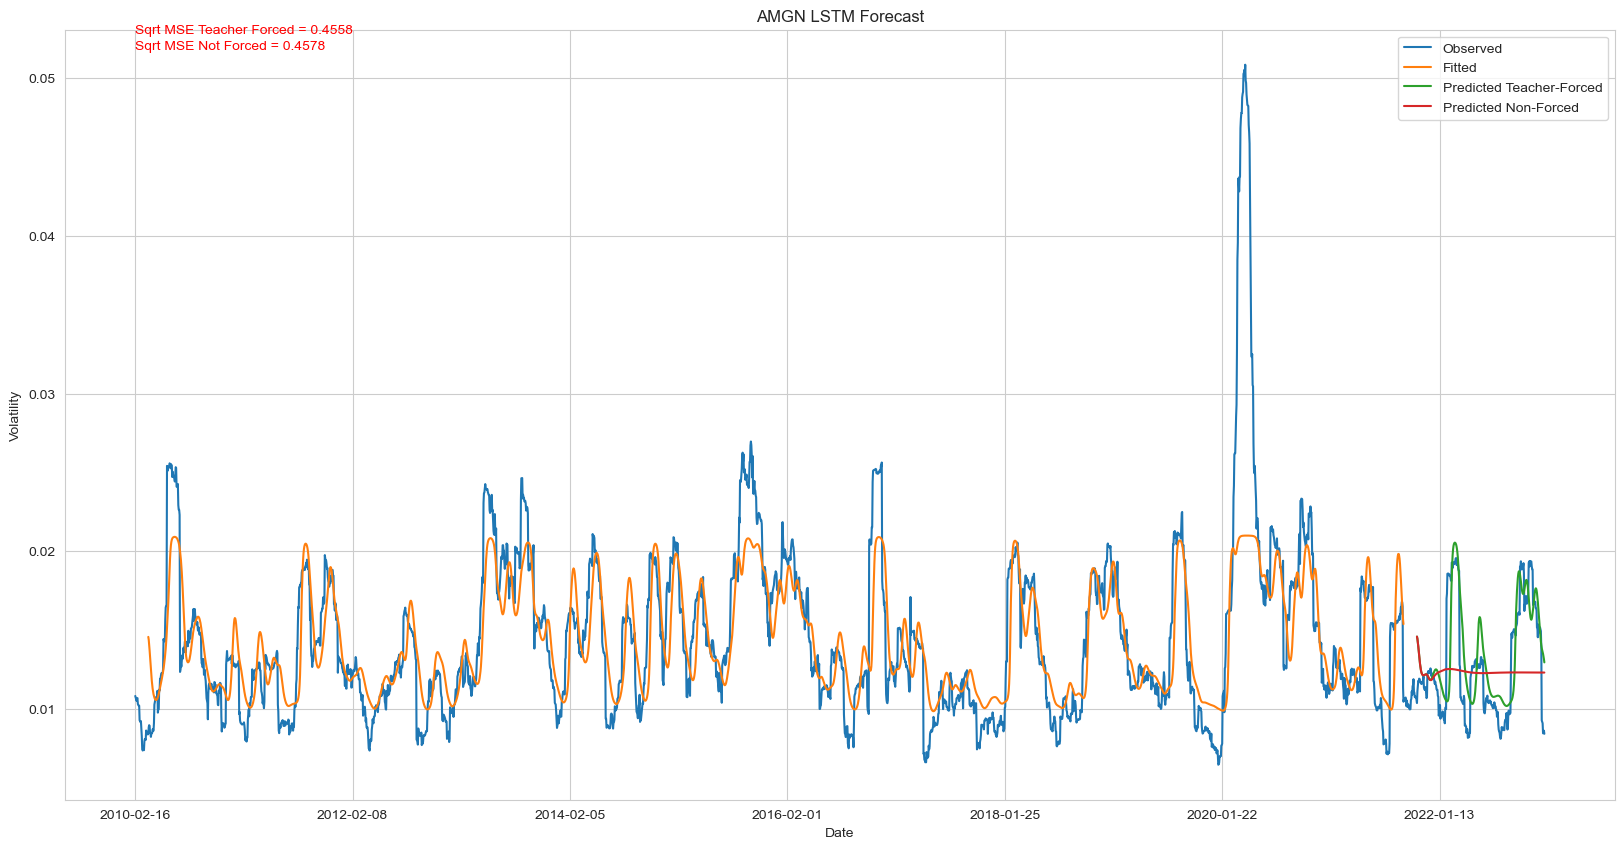

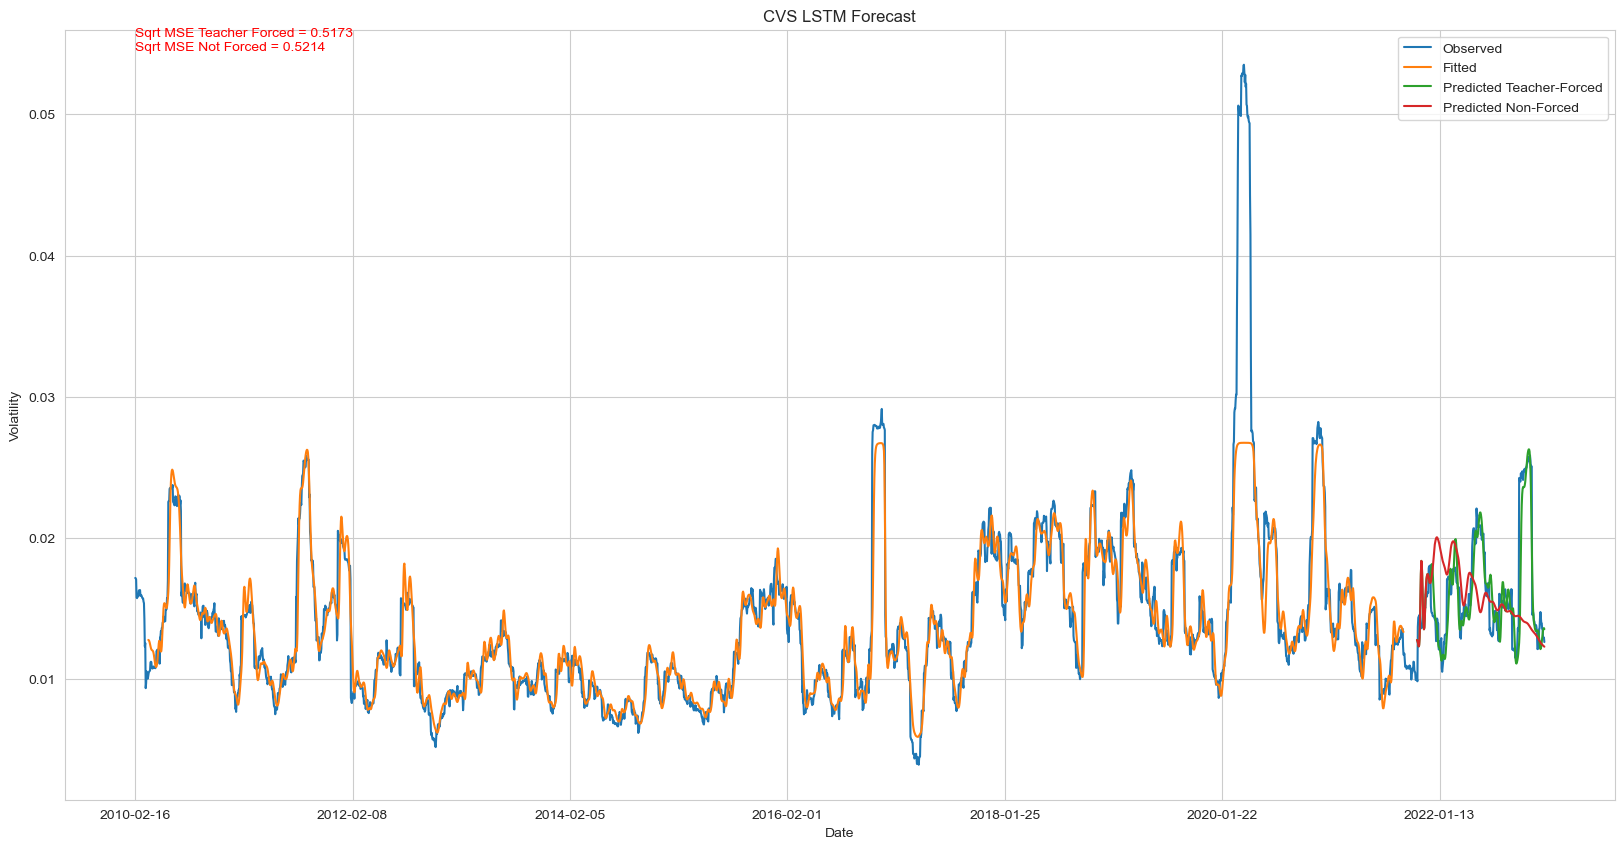

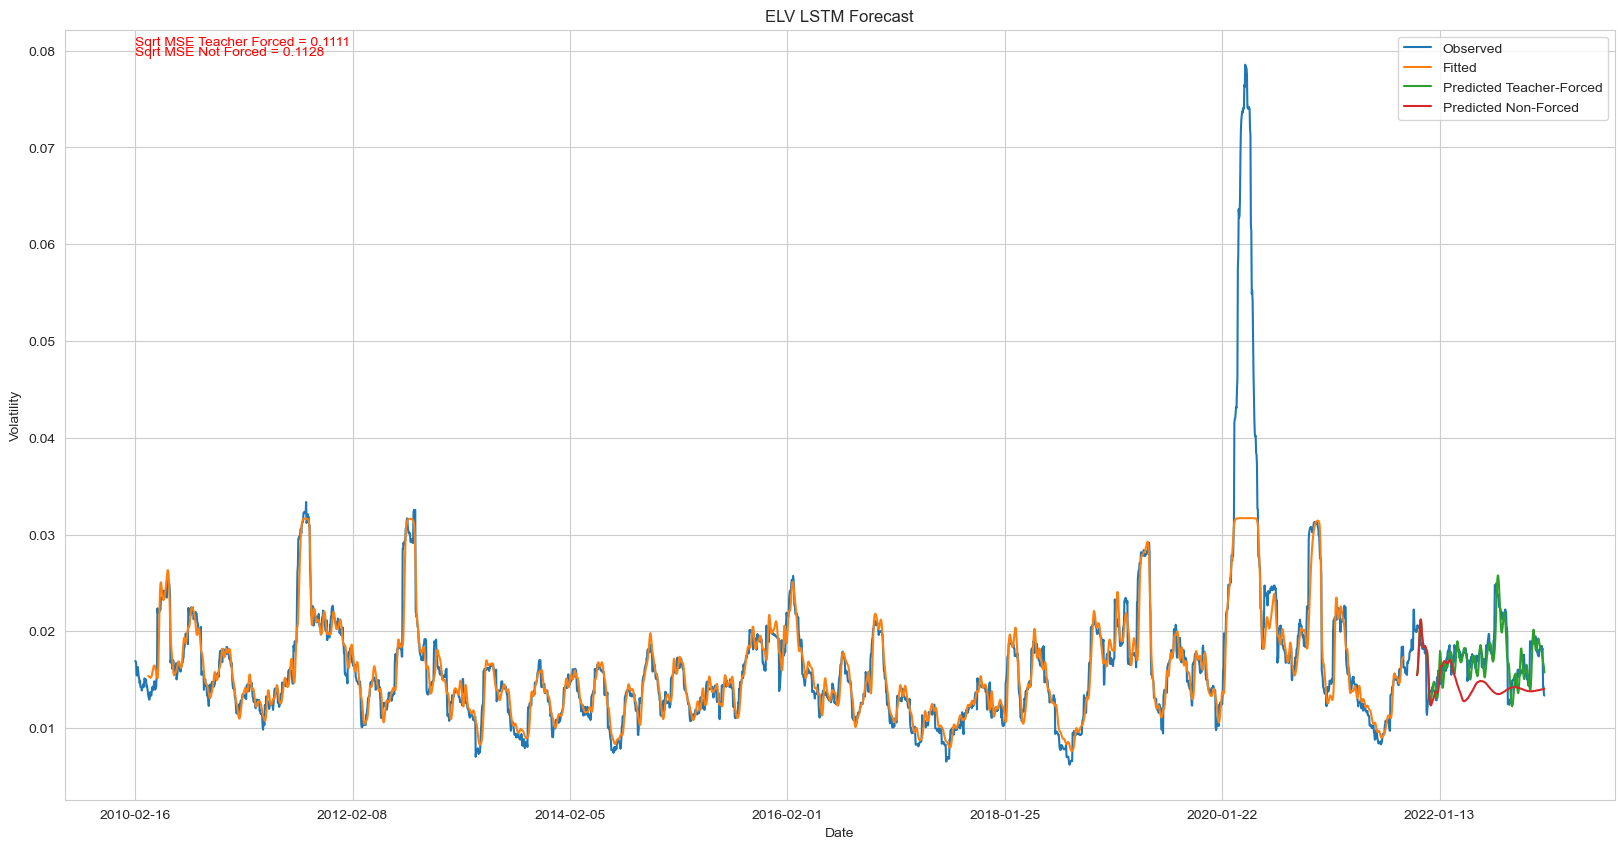

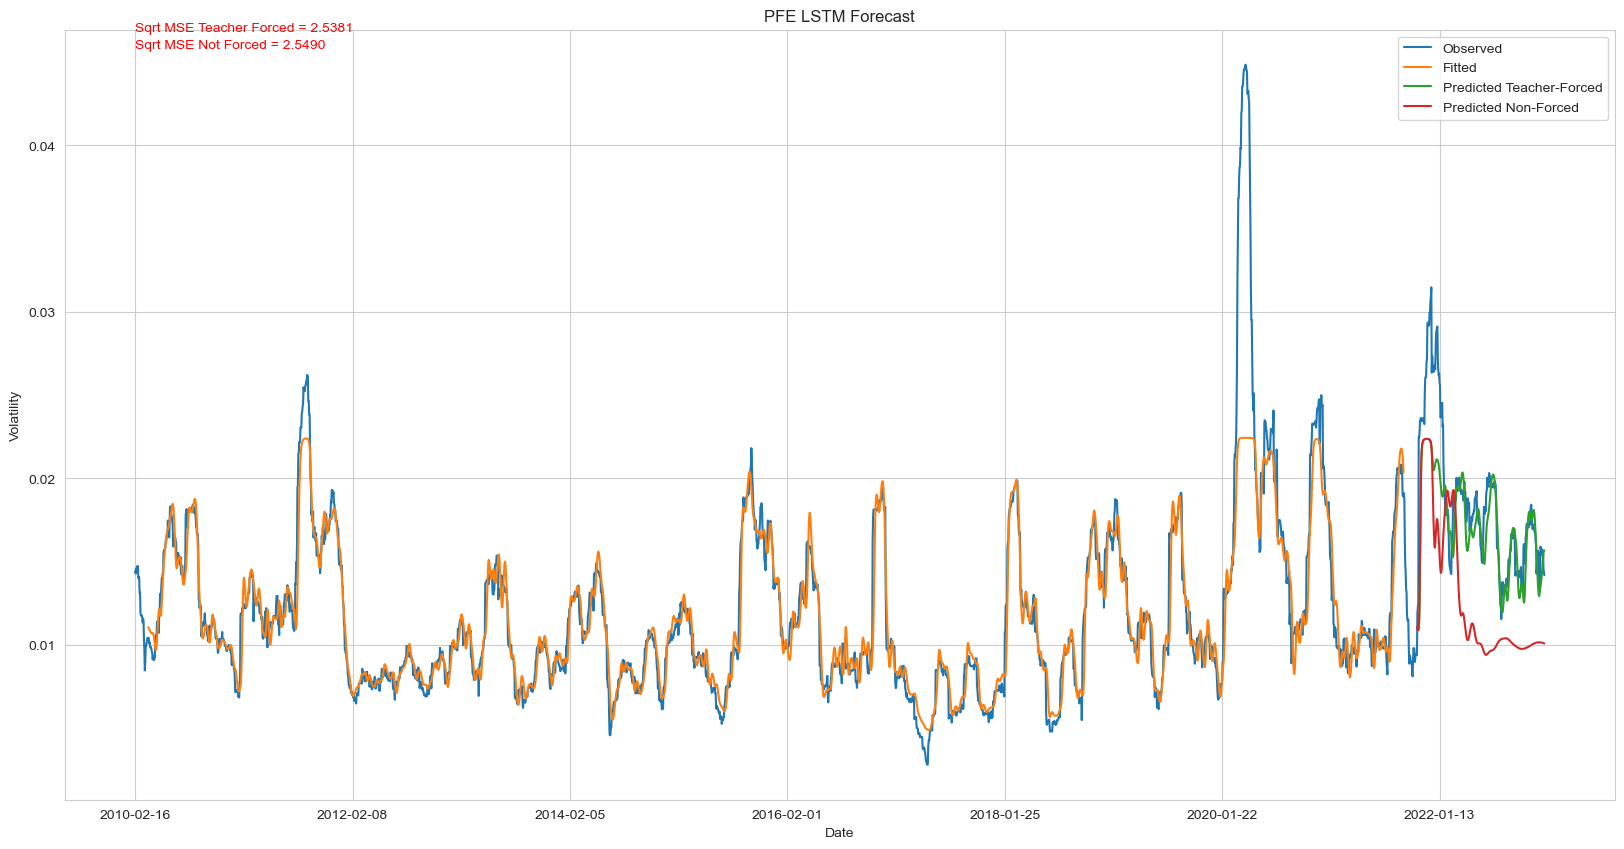

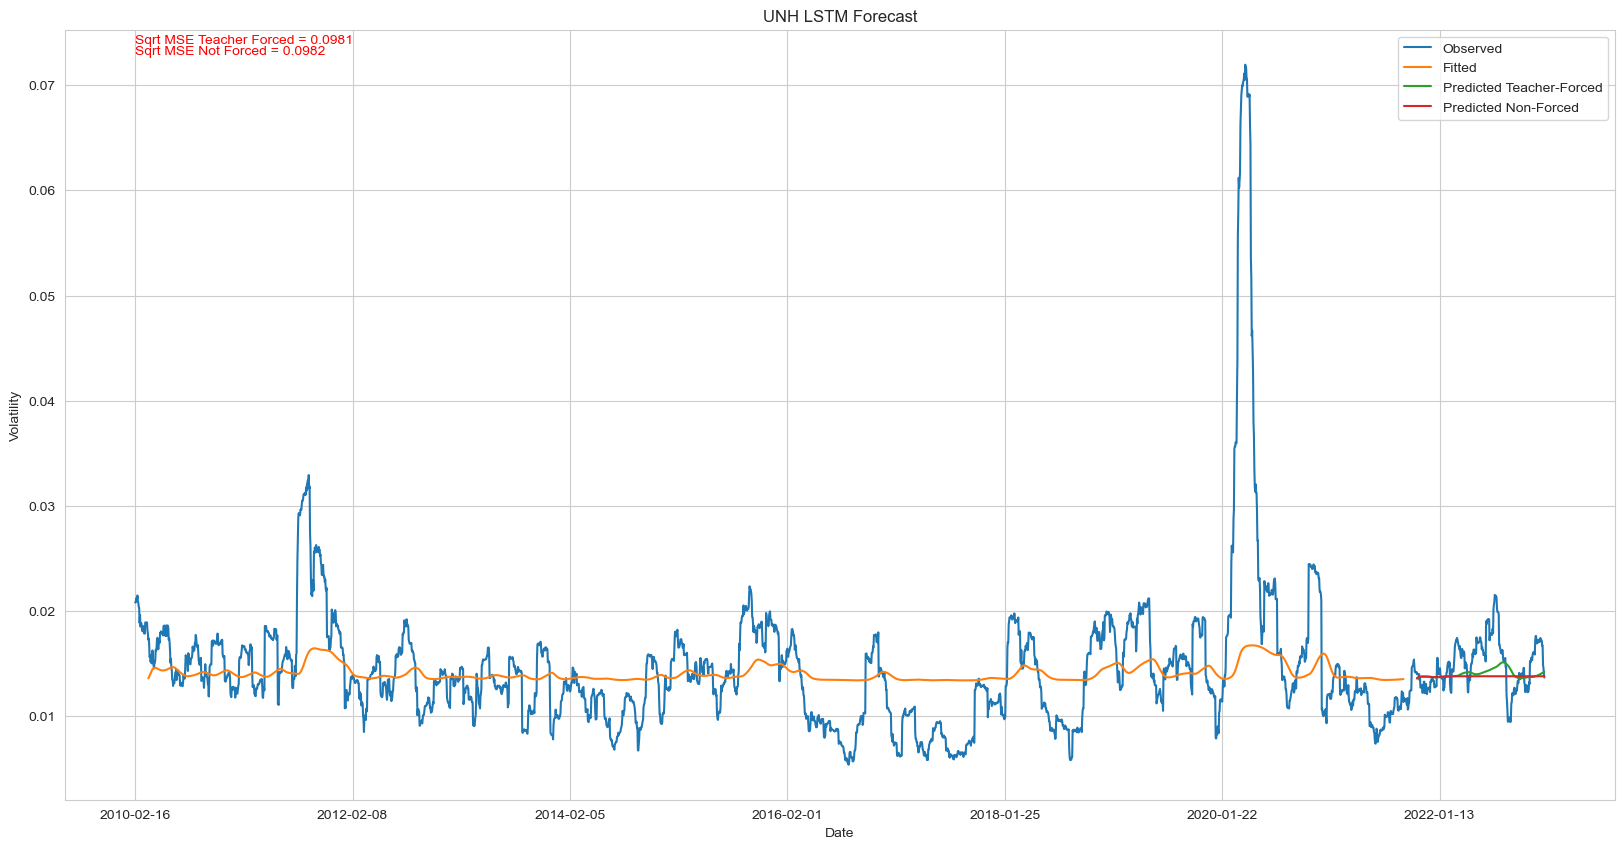

In [21]:
healthcare_test_mses = {}

with torch.no_grad():
    for stock in healthcare_tickers:
        window=MODEL_CONFIGS['window_size']

        full_train = pd.concat([healthcare_train, healthcare_val])
        train_tensor = torch.tensor(full_train[f'{stock}_volatility'].values, dtype=torch.float)
        mean, std = healthcare_means[stock], healthcare_stds[stock]
        train_tensor = (train_tensor - mean) / std

        test_tensor = torch.tensor(healthcare_test[f'{stock}_volatility'].values, dtype=torch.float)
        test_tensor = (test_tensor - mean) / std

        X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        X_test = test_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_test = test_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        model = healthcare_models[stock]

        fitted, _ = model(X_train)
        pred_forced, _ = model(X_test)
        # predicting the values given a 30 day initial set
        pred_infer = model.predict(X_test[:, :30, :], n_days=y_test.size(1) - 30, keep_init=True)
        
        fitted = (fitted * std) + mean
        pred_forced = (pred_forced * std) + mean
        pred_infer = (pred_infer * std) + mean

        criterion = torch.nn.MSELoss()
        loss_forced = criterion(pred_forced[:, :-1], y_test).item()
        loss_infer = criterion(pred_infer, y_test).item()

        ## make dataframes to be plotted
        obs_df = pd.DataFrame(data=healthcare[f"{stock}_volatility"].values,
                              index=healthcare.Date,
                              columns=["Observed"])

        fit_df = pd.DataFrame(data=fitted[:, :-1].squeeze().numpy(),
                              index=full_train.Date[window:],
                              columns=["Fitted"])

        pred_forced_df = pd.DataFrame(data=pred_forced[:, :-1].squeeze().numpy(),
                               index=healthcare_test.Date[window:],
                               columns=["Predicted Teacher-Forced"])
        pred_infer_df = pd.DataFrame(data=pred_infer.squeeze().numpy(),
                                    index=healthcare_test.Date[window:],
                                    columns=["Predicted Non-Forced"])

        df = pd.concat([obs_df, fit_df, pred_forced_df, pred_infer_df], axis=1)

        ## make the plot 
        ax = df.plot(y=["Observed", "Fitted", "Predicted Teacher-Forced", "Predicted Non-Forced"],
            figsize=(20,10),
            ylabel="Volatility",
            title=f"{stock} LSTM Forecast")
        ax.text(0,df["Observed"].max() + 0.002, f"Sqrt MSE Teacher Forced = {loss_forced:.4f}",
                color="red")
        ax.text(0,df["Observed"].max() + 0.001, f"Sqrt MSE Not Forced = {loss_infer:.4f}",
                color="red")

        healthcare_test_mses[stock] = (loss_forced, loss_infer)


In [22]:
print_mse_results(healthcare_test_mses)

Stock	Test MSE Forced		Test MSE Not Forced
AMGN	0.45575442910194397	0.45776256918907166
CVS	0.5172895789146423	0.521361768245697
ELV	0.11112207919359207	0.1127791628241539
PFE	2.5380818843841553	2.5490036010742188
UNH	0.09814290702342987	0.09822943061590195


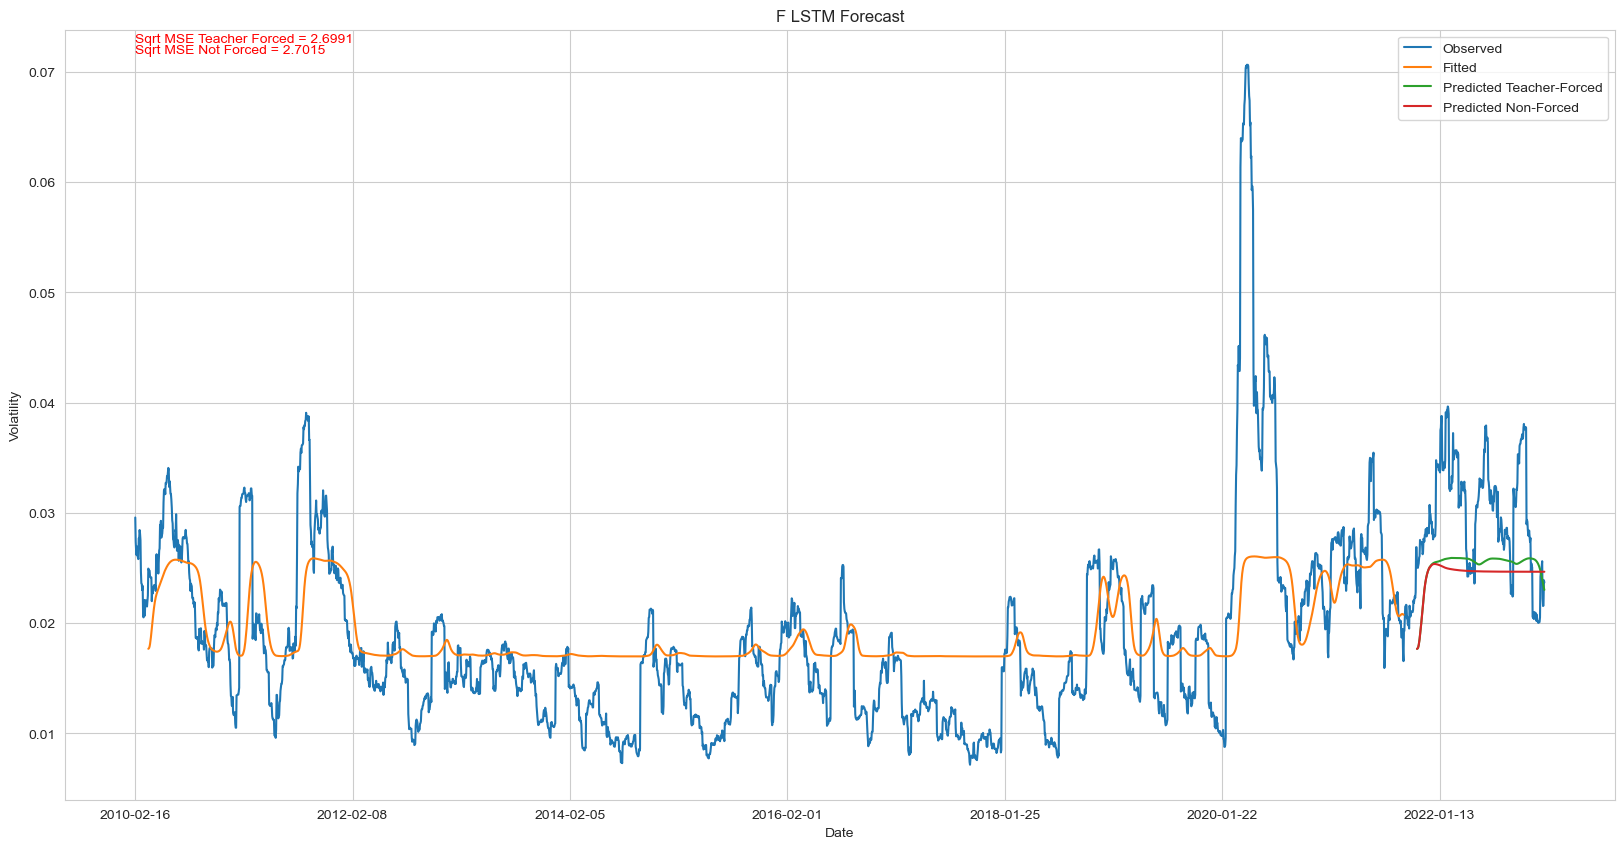

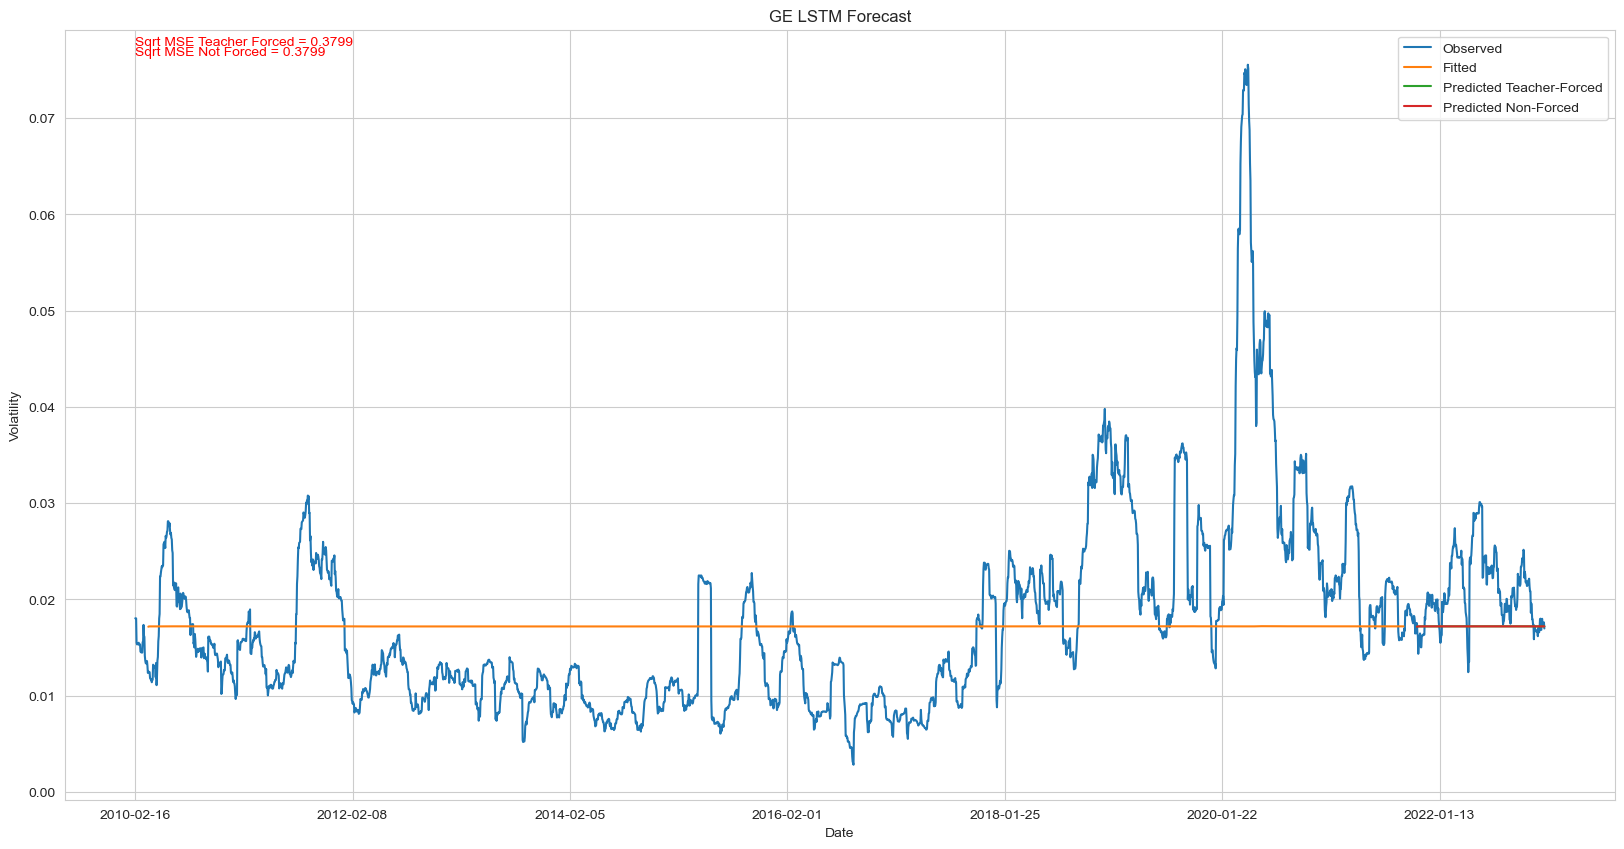

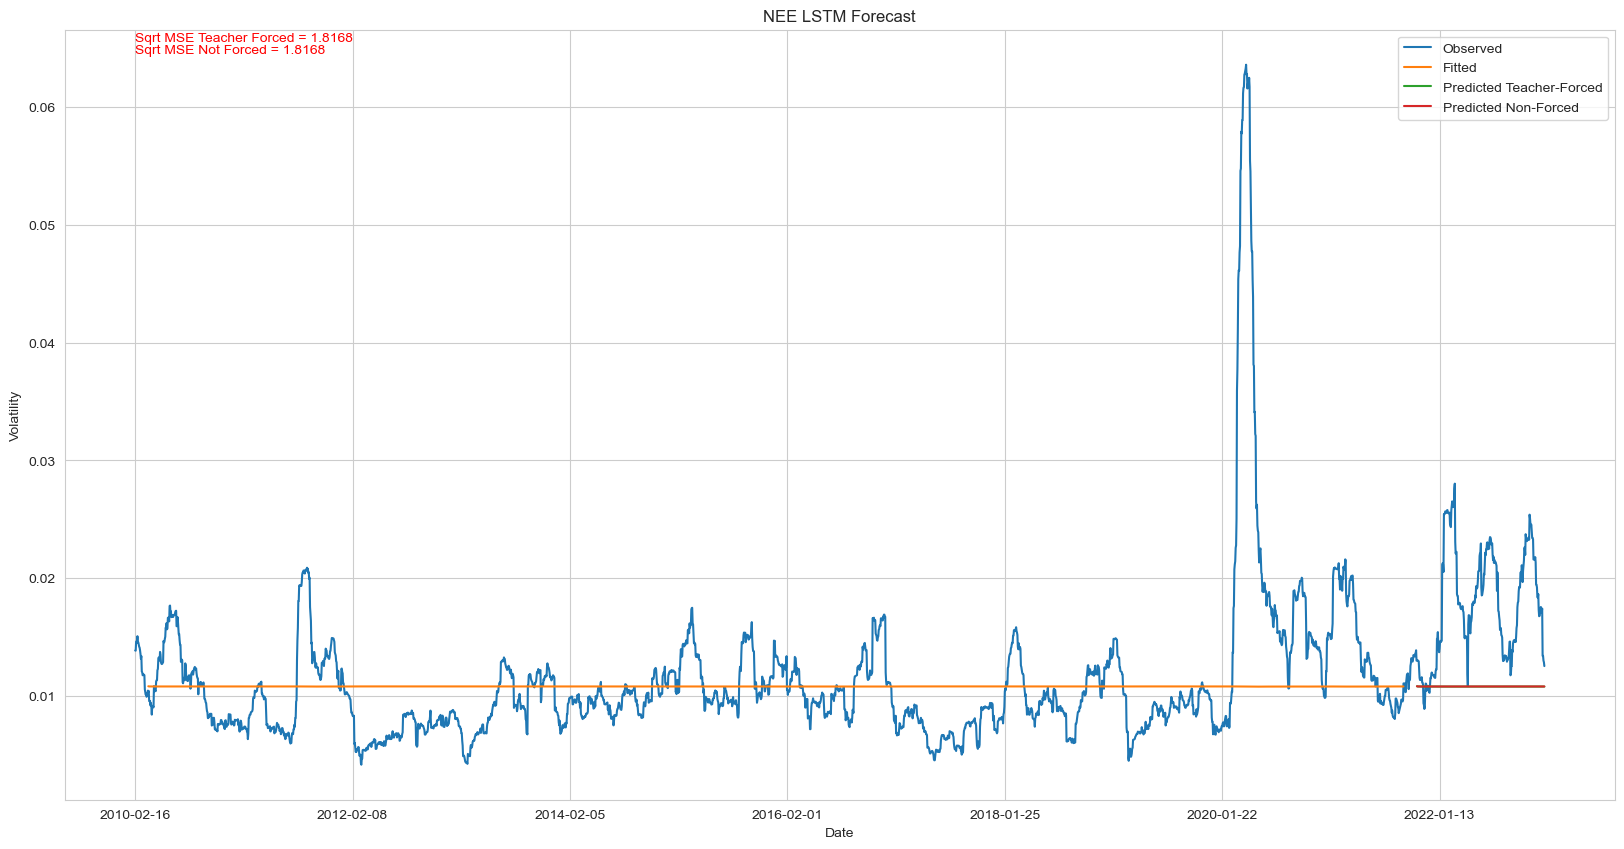

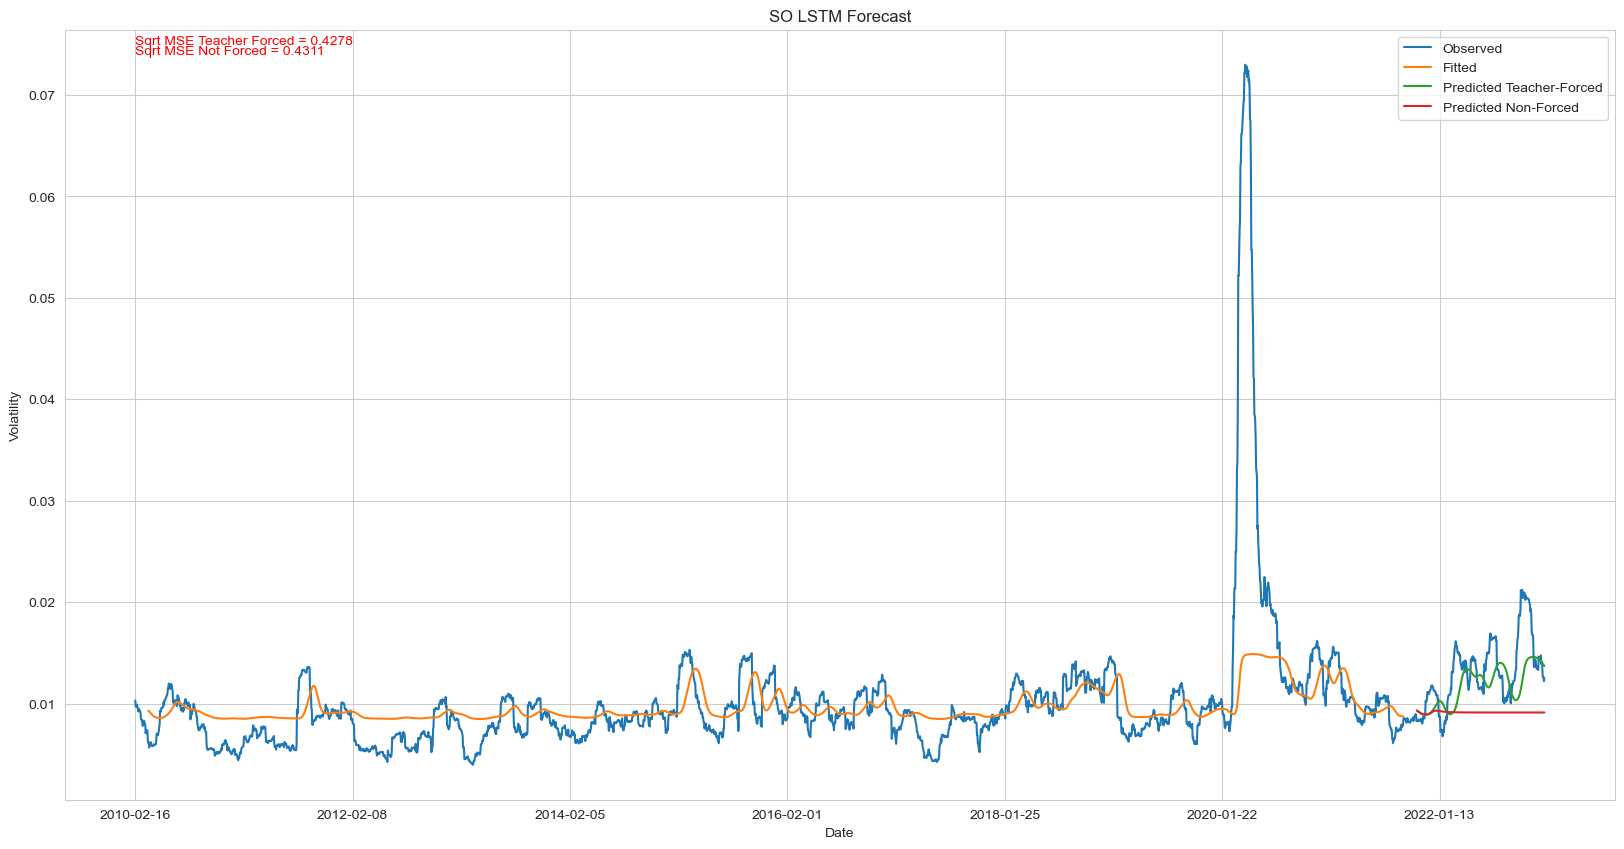

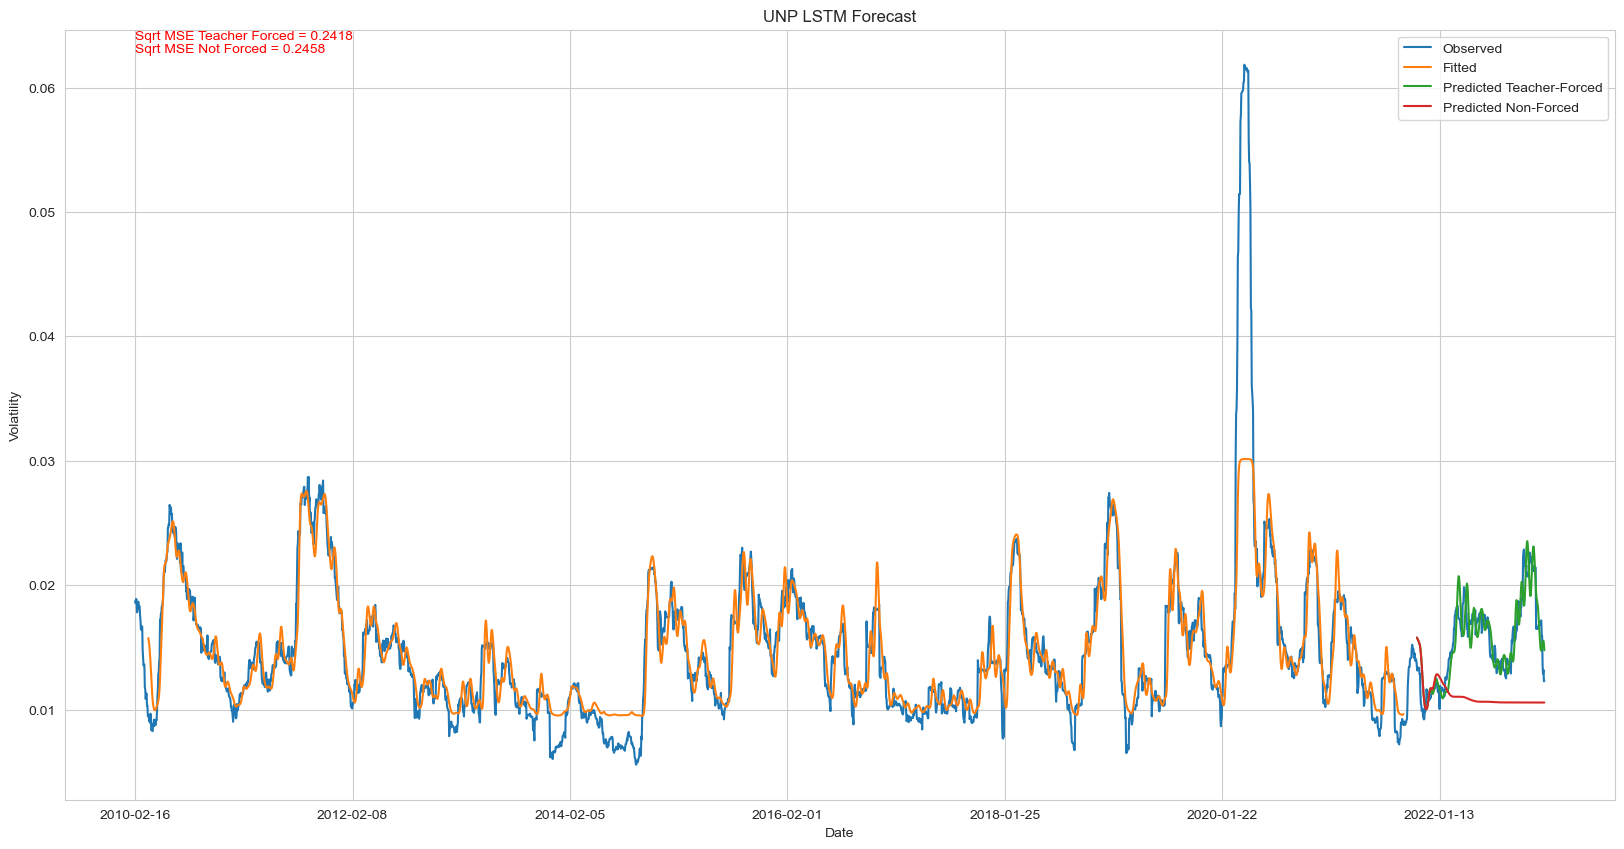

In [23]:
industrial_test_mses = {}

with torch.no_grad():
    for stock in industrial_tickers:
        window=MODEL_CONFIGS['window_size']

        full_train = pd.concat([industrial_train, industrial_val])
        train_tensor = torch.tensor(full_train[f'{stock}_volatility'].values, dtype=torch.float)
        mean, std = industrial_means[stock], industrial_stds[stock]
        train_tensor = (train_tensor - mean) / std

        test_tensor = torch.tensor(industrial_test[f'{stock}_volatility'].values, dtype=torch.float)
        test_tensor = (test_tensor - mean) / std

        X_train = train_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_train = train_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        X_test = test_tensor.unfold(0, MODEL_CONFIGS['window_size'], 1).unsqueeze(0)
        y_test = test_tensor[MODEL_CONFIGS['window_size']:].unsqueeze(0)

        model = industrial_models[stock]

        fitted, _ = model(X_train)
        pred_forced, _ = model(X_test)
        # predicting the values given a 30 day initial set
        pred_infer = model.predict(X_test[:, :30, :], n_days=y_test.size(1) - 30, keep_init=True)
        
        fitted = (fitted * std) + mean
        pred_forced = (pred_forced * std) + mean
        pred_infer = (pred_infer * std) + mean

        criterion = torch.nn.MSELoss()
        loss_forced = criterion(pred_forced[:, :-1], y_test).item()
        loss_infer = criterion(pred_infer, y_test).item()

        ## make dataframes to be plotted
        obs_df = pd.DataFrame(data=industrial[f"{stock}_volatility"].values,
                              index=industrial.Date,
                              columns=["Observed"])

        fit_df = pd.DataFrame(data=fitted[:, :-1].squeeze().numpy(),
                              index=full_train.Date[window:],
                              columns=["Fitted"])

        pred_forced_df = pd.DataFrame(data=pred_forced[:, :-1].squeeze().numpy(),
                               index=industrial_test.Date[window:],
                               columns=["Predicted Teacher-Forced"])
        pred_infer_df = pd.DataFrame(data=pred_infer.squeeze().numpy(),
                                    index=industrial_test.Date[window:],
                                    columns=["Predicted Non-Forced"])

        df = pd.concat([obs_df, fit_df, pred_forced_df, pred_infer_df], axis=1)

        ## make the plot 
        ax = df.plot(y=["Observed", "Fitted", "Predicted Teacher-Forced", "Predicted Non-Forced"],
            figsize=(20,10),
            ylabel="Volatility",
            title=f"{stock} LSTM Forecast")
        ax.text(0,df["Observed"].max() + 0.002, f"Sqrt MSE Teacher Forced = {loss_forced:.4f}",
                color="red")
        ax.text(0,df["Observed"].max() + 0.001, f"Sqrt MSE Not Forced = {loss_infer:.4f}",
                color="red")

        industrial_test_mses[stock] = (loss_forced, loss_infer)


In [24]:
print_mse_results(industrial_test_mses)

Stock	Test MSE Forced		Test MSE Not Forced
F	2.6991071701049805	2.7015397548675537
GE	0.37987422943115234	0.379877507686615
NEE	1.816843867301941	1.8168262243270874
SO	0.42778196930885315	0.43114009499549866
UNP	0.24181236326694489	0.24578982591629028
